<a href="https://colab.research.google.com/github/FengruiJing/TrafficVideoVisualEnvironment/blob/main/TrafficVideoVisualEnvironment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install torch torchvision matplotlib numpy opencv-python


In [ ]:
#mount google drive
from google.colab import drive
drive.mount('/content/gdrive')
import os
os.chdir("/content/gdrive/My Drive/Colab Notebooks")
#list the files
!ls

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
 A0927.gpx
 activity_area_results20241231.csv
 activity_area_results.csv
 activity_radius_results.csv
 activity_radius_results_in_meters.csv
 ALL_VARIAIBLES2-1-coord1.xlsx
 ALL_VARIAIBLES2-1-coord.xlsx
 ALL_VARIAIBLES2-1.csv
 ALL_VARIAIBLES2-1.xlsx
 B0928.gpx
 C0928.gpx
 Categorical_Variable_Summary_gender.xlsx
 Categorical_Variable_Summary_Park.xlsx
 Community_variables_finnal_test_tree.xlsx
 Community_variables_finnal_test.xlsx
 Community_variables_with_water_combinations_MultplBy.xlsx
 Community_variables_with_water_combinations.xlsx
 county_county.tsv
 COVID_RNN.ipynb
 COVID-RNN-Public.ipynb
 cq01_20240926.gpx
 cq02_20240926.gpx
 cq03_20240926.gpx
 cq04_20240927.gpx
 cq05_20240927.gpx
 cq06_20240928.gpx
 cq07_20240928.gpx
 cq08_20240928.gpx
 cq09_20240928.gpx
 cq10_20240928.gpx
 cq11_20240928.gpx
 cq12_20240928.gpx
 cq13_20240928.gpx
 cq14_20240928.gpx


In [ ]:
import torch
from torchvision import models, transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
# 检查文件是否存在
import os
image_path = 'Photo2.jpg'
if os.path.exists(image_path):
    print("File exists!")
else:
    print("File not found!")


File exists!


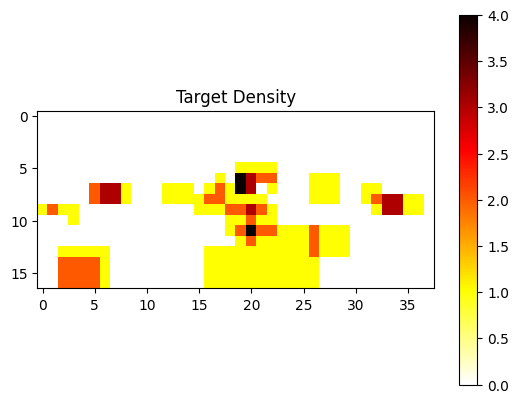

空间拥堵指数 (SCi): 0.002137130970857123
混行严重度指数 (Mxi): 5.592847248107887


In [ ]:
# 1. 加载预训练的Mask R-CNN模型
model = models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()  # 设置为评估模式

# 2. 加载图像并进行预处理
def preprocess_image(image_path):
    image = cv2.imread(image_path)  # 读取图像
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # 转换为RGB格式
    transform = transforms.Compose([transforms.ToTensor()])  # 归一化
    image_tensor = transform(image_rgb)  # 转换为tensor
    image_tensor = image_tensor.unsqueeze(0)  # 添加批处理维度
    return image, image_tensor

# 3. 执行目标检测和实例分割
def detect_objects(image_path):
    image, image_tensor = preprocess_image(image_path)
    with torch.no_grad():  # 禁用梯度计算，减少内存消耗
        prediction = model(image_tensor)  # 进行推断

    return image, prediction

# 4. 计算目标的边界框重叠度（IoU）
def calculate_iou(box1, box2):
    # 计算两个框的交集
    x1, y1, x2, y2 = box1
    x3, y3, x4, y4 = box2

    # 计算交集坐标
    xi1, yi1 = max(x1, x3), max(y1, y3)
    xi2, yi2 = min(x2, x4), min(y2, y4)

    # 计算交集面积
    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)

    # 计算两个框的面积
    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x4 - x3) * (y4 - y3)

    # 计算并集面积
    union_area = box1_area + box2_area - inter_area

    # 计算IoU
    iou = inter_area / union_area
    return iou

# 5. 计算目标之间的最小距离
def calculate_min_distance(boxes):
    min_distance = float('inf')
    # 遍历所有目标框，计算最小距离
    for i in range(len(boxes)):
        for j in range(i + 1, len(boxes)):
            # 计算两个目标的中心点距离
            x1, y1, x2, y2 = boxes[i]
            x3, y3, x4, y4 = boxes[j]
            center1 = ((x1 + x2) / 2, (y1 + y2) / 2)
            center2 = ((x3 + x4) / 2, (y3 + y4) / 2)
            distance = np.linalg.norm(np.array(center1) - np.array(center2))
            min_distance = min(min_distance, distance)
    return min_distance

# 6. 计算目标密度
def calculate_density(image, boxes, target_size=(50, 50)):
    # 将图像划分为小区域并计算目标密度
    height, width, _ = image.shape
    grid_size = target_size
    num_grids_x = width // grid_size[0]
    num_grids_y = height // grid_size[1]

    grid_counts = np.zeros((num_grids_y, num_grids_x))
    for box in boxes:
        x1, y1, x2, y2 = box
        grid_x1, grid_y1 = int(x1 // grid_size[0]), int(y1 // grid_size[1])
        grid_x2, grid_y2 = int(x2 // grid_size[0]), int(y2 // grid_size[1])
        grid_counts[grid_y1:grid_y2+1, grid_x1:grid_x2+1] += 1  # 增加对应区域内的目标数量

    # 可视化密度
    plt.imshow(grid_counts, cmap='hot_r', interpolation='nearest')
    plt.title("Target Density")
    plt.colorbar()
    plt.show()

# 7. 计算空间拥堵指数 (SCi) 和混行严重度指数 (Mxi)
def calculate_congestion_indices(image_path):
    image, prediction = detect_objects(image_path)
    boxes = prediction[0]['boxes'].cpu().numpy()  # 获取目标的边界框
    labels = prediction[0]['labels'].cpu().numpy()  # 获取目标的类别
    scores = prediction[0]['scores'].cpu().numpy()  # 获取目标的置信度

    # 过滤掉置信度低的目标
    boxes = boxes[scores > 0.5]
    labels = labels[scores > 0.5]

    # 计算IoU，最小距离和目标密度
    iou_matrix = np.zeros((len(boxes), len(boxes)))
    for i in range(len(boxes)):
        for j in range(i + 1, len(boxes)):
            iou_matrix[i, j] = calculate_iou(boxes[i], boxes[j])

    min_distance = calculate_min_distance(boxes)
    calculate_density(image, boxes)

    # 综合评估空间拥堵和混行严重度
    sc_index = np.mean(iou_matrix)  # 空间拥堵指数
    mx_index = min_distance  # 混行严重度指数

    return sc_index, mx_index

# 执行计算
image_path = 'Road4.png'  # 替换为您的图像路径
sc_index, mx_index = calculate_congestion_indices(image_path)

print(f"空间拥堵指数 (SCi): {sc_index}")
print(f"混行严重度指数 (Mxi): {mx_index}")

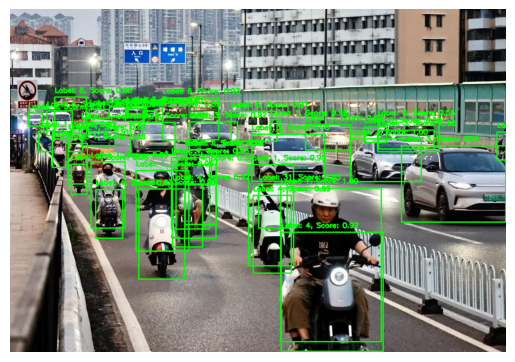

In [ ]:
import torch
from torchvision import models, transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 加载预训练的Mask R-CNN模型
model = models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()  # 设置为评估模式

# 载入图像并进行预处理
def preprocess_image(image_path):
    image = cv2.imread(image_path)  # 读取图像
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # 转换为RGB格式
    transform = transforms.Compose([transforms.ToTensor()])  # 归一化
    image_tensor = transform(image_rgb)  # 转换为tensor
    image_tensor = image_tensor.unsqueeze(0)  # 添加批处理维度
    return image, image_tensor

# 执行目标检测
def detect_objects(image_path):
    image, image_tensor = preprocess_image(image_path)
    with torch.no_grad():  # 禁用梯度计算，减少内存消耗
        prediction = model(image_tensor)  # 进行推断

    return image, prediction

# 解析检测结果
def parse_prediction(prediction):
    labels = prediction[0]['labels'].numpy()  # 获取所有检测目标的类别标签
    boxes = prediction[0]['boxes'].detach().numpy()  # 获取目标的边界框
    scores = prediction[0]['scores'].detach().numpy()  # 获取目标的置信度分数

    return labels, boxes, scores

# 显示检测到的目标
def show_detected_objects(image, labels, boxes, scores, threshold=0.5):
    for i in range(len(labels)):
        if scores[i] > threshold:  # 只显示置信度大于阈值的目标
            box = boxes[i]
            label = labels[i]
            # 绘制边界框
            cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0, 255, 0), 2)
            # 显示类别和分数
            cv2.putText(image, f"Label: {label}, Score: {scores[i]:.2f}", (int(box[0]), int(box[1]) - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # 转换为RGB格式进行显示
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.axis('off')  # 关闭坐标轴
    plt.show()

# 主函数
image_path = 'Photo3.jpg'  # 图片路径，替换成实际路径
image, prediction = detect_objects(image_path)
labels, boxes, scores = parse_prediction(prediction)
show_detected_objects(image, labels, boxes, scores)


In [ ]:
import torch
from torchvision import models, transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1. 加载预训练的Mask R-CNN模型
model = models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()  # 设置为评估模式

# 2. 加载图像并进行预处理
def preprocess_image(image_path):
    """
    读取图像并进行预处理：转换为RGB格式并转换为tensor。
    """
    image = cv2.imread(image_path)  # 读取图像
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # 转换为RGB格式
    transform = transforms.Compose([transforms.ToTensor()])  # 归一化
    image_tensor = transform(image_rgb)  # 转换为tensor
    image_tensor = image_tensor.unsqueeze(0)  # 添加批处理维度
    return image, image_tensor

# 3. 执行目标检测和实例分割
def detect_objects(image_path):
    image, image_tensor = preprocess_image(image_path)
    with torch.no_grad():  # 禁用梯度计算，减少内存消耗
        prediction = model(image_tensor)  # 进行推断

    return image, prediction

# 4. 计算目标的边界框重叠度（IoU）
def calculate_iou(box1, box2):
    """
    计算两个边界框的IoU（交并比）。
    参数:
    - box1, box2：格式为 [x1, y1, x2, y2]，其中 (x1, y1) 是左上角，(x2, y2) 是右下角。
    返回:
    - IoU：交并比
    """
    # 计算交集的坐标
    x1, y1, x2, y2 = box1
    x1_2, y1_2, x2_2, y2_2 = box2

    # 计算交集区域的面积
    xi1 = max(x1, x1_2)
    yi1 = max(y1, y1_2)
    xi2 = min(x2, x2_2)
    yi2 = min(y2, y2_2)

    # 如果没有交集，返回IoU为0
    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)

    # 计算两个框的面积
    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2_2 - x1_2) * (y2_2 - y1_2)

    # 计算并集的面积
    union_area = box1_area + box2_area - inter_area

    # 返回IoU
    iou = inter_area / union_area if union_area > 0 else 0
    return iou

# 5. 计算空间拥堵度（SCi）
def calculate_sci(prediction):
    """
    计算空间拥堵度（SCi），基于IoU值计算多个目标之间的拥堵程度。
    """
    boxes = prediction[0]['boxes'].cpu().numpy()
    num_objects = len(boxes)
    iou_values = []

    # 计算每一对目标之间的IoU
    for i in range(num_objects):
        for j in range(i + 1, num_objects):
            iou = calculate_iou(boxes[i], boxes[j])
            iou_values.append(iou)

    # 计算SCi（这里取平均IoU值作为空间拥堵度）
    sci = np.mean(iou_values) if iou_values else 0
    return sci

# 6. 计算混行严重度（Mxi）
def calculate_mxi(prediction):
    """
    计算混行严重度（Mxi），基于目标之间的最小距离计算混行严重度。
    """
    boxes = prediction[0]['boxes'].cpu().numpy()
    num_objects = len(boxes)
    min_distances = []

    # 计算每一对目标之间的最小距离
    for i in range(num_objects):
        for j in range(i + 1, num_objects):
            # 计算目标框的中心点
            x1, y1, x2, y2 = boxes[i]
            x1_2, y1_2, x2_2, y2_2 = boxes[j]
            center1 = ((x1 + x2) / 2, (y1 + y2) / 2)
            center2 = ((x1_2 + x2_2) / 2, (y1_2 + y2_2) / 2)

            # 计算两目标之间的欧氏距离
            distance = np.linalg.norm(np.array(center1) - np.array(center2))
            min_distances.append(distance)

    # 计算Mxi（这里取最小距离的平均值作为混行严重度）
    mxi = np.mean(min_distances) if min_distances else 0
    return mxi

# 示例使用
image_path = 'Photo2.jpg'
image, prediction = detect_objects(image_path)

# 计算空间拥堵度（SCi）和混行严重度（Mxi）
sci = calculate_sci(prediction)
mxi = calculate_mxi(prediction)

print(f"空间拥堵度（SCi）：{sci}")
print(f"混行严重度（Mxi）：{mxi}")


空间拥堵度（SCi）：0.0035276052981351664
混行严重度（Mxi）：313.9204431382131


空间拥堵度（SCi）: 0.6479281783103943
混行严重度（Mxi）: 1.8442775857467482


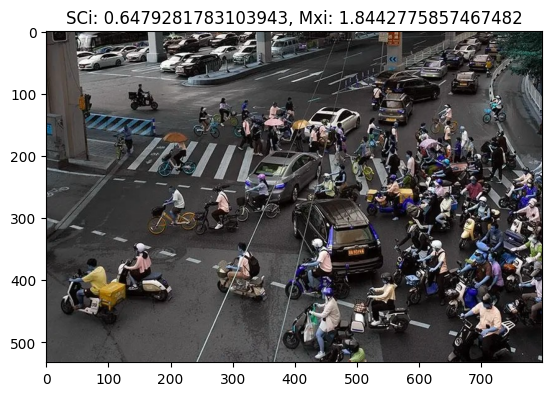

In [ ]:
import torch
from torchvision import models, transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1. 加载预训练的Mask R-CNN模型
model = models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()  # 设置为评估模式

# 2. 加载图像并进行预处理
def preprocess_image(image_path):
    image = cv2.imread(image_path)  # 读取图像
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # 转换为RGB格式
    transform = transforms.Compose([transforms.ToTensor()])  # 归一化
    image_tensor = transform(image_rgb)  # 转换为tensor
    image_tensor = image_tensor.unsqueeze(0)  # 添加批处理维度
    return image, image_tensor

# 3. 执行目标检测和实例分割
def detect_objects(image_path):
    image, image_tensor = preprocess_image(image_path)
    with torch.no_grad():  # 禁用梯度计算，减少内存消耗
        prediction = model(image_tensor)  # 进行推断
    return image, prediction

# 4. 计算目标的边界框重叠度（IoU）
def calculate_iou(box1, box2):
    """
    计算两个边界框的IoU（交并比）。

    参数:
    - box1, box2：格式为 [x1, y1, x2, y2]，其中 (x1, y1) 是左上角，(x2, y2) 是右下角。

    返回:
    - IoU：交并比
    """
    x1, y1, x2, y2 = box1
    x1_2, y1_2, x2_2, y2_2 = box2

    xi1 = max(x1, x1_2)
    yi1 = max(y1, y1_2)
    xi2 = min(x2, x2_2)
    yi2 = min(y2, y2_2)

    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)  # 交集面积
    box1_area = (x2 - x1) * (y2 - y1)  # box1面积
    box2_area = (x2_2 - x1_2) * (y2_2 - y1_2)  # box2面积

    union_area = box1_area + box2_area - inter_area  # 并集面积
    iou = inter_area / union_area  # 交并比
    return iou

# 5. 计算空间拥堵度（SCi）
def calculate_space_congestion(boxes, iou_threshold=0.5):
    """
    计算空间拥堵度（SCi）：计算所有目标之间的IoU，并返回平均IoU作为空间拥堵度。
    """
    ious = []
    for i in range(len(boxes)):
        for j in range(i + 1, len(boxes)):
            iou = calculate_iou(boxes[i], boxes[j])
            if iou > iou_threshold:  # 只考虑IoU大于某个阈值的目标对
                ious.append(iou)

    if len(ious) > 0:
        return np.mean(ious)  # 返回IoU的平均值
    return 0.0  # 如果没有足够的交集，则返回0

# 6. 计算混行严重度（Mxi）
def calculate_mixed_severity(boxes):
    """
    计算混行严重度（Mxi）：计算所有目标的最小距离。
    """
    def calculate_distance(box1, box2):
        """
        计算两个边界框的最小中心距离。
        """
        x1, y1, x2, y2 = box1
        x1_2, y1_2, x2_2, y2_2 = box2
        center1 = ((x1 + x2) / 2, (y1 + y2) / 2)
        center2 = ((x1_2 + x2_2) / 2, (y1_2 + y2_2) / 2)
        distance = np.sqrt((center1[0] - center2[0]) ** 2 + (center1[1] - center2[1]) ** 2)
        return distance

    min_distances = []
    for i in range(len(boxes)):
        for j in range(i + 1, len(boxes)):
            distance = calculate_distance(boxes[i], boxes[j])
            min_distances.append(distance)

    if len(min_distances) > 0:
        return np.min(min_distances)  # 返回最小距离
    return 0.0  # 如果没有目标，返回0

# 7. 计算目标检测后的空间拥堵度和混行严重度
def analyze_image(image_path):
    image, prediction = detect_objects(image_path)

    # 获取目标的边界框
    boxes = prediction[0]['boxes'].cpu().numpy()

    # 计算空间拥堵度（SCi）
    sc = calculate_space_congestion(boxes)
    print(f"空间拥堵度（SCi）: {sc}")

    # 计算混行严重度（Mxi）
    mx = calculate_mixed_severity(boxes)
    print(f"混行严重度（Mxi）: {mx}")

    # 可视化结果（选项）
    plt.imshow(image)
    plt.title(f"SCi: {sc}, Mxi: {mx}")
    plt.show()

# 测试代码
image_path = "Photo2.jpg"  # 替换为实际的图像路径
analyze_image(image_path)

空间拥堵度（SCi）: 0.7800086736679077
混行严重度（Mxi）: 0.04026993619756106


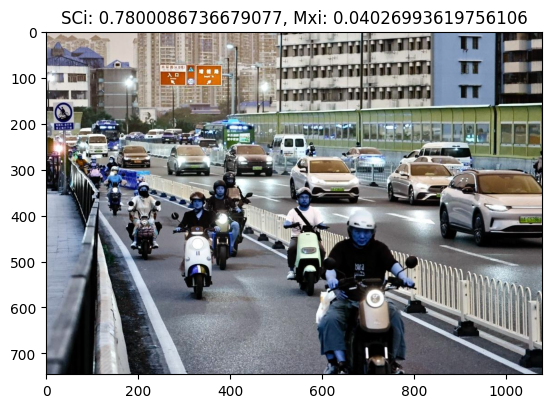

In [ ]:
import torch
from torchvision import models, transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1. 加载预训练的Mask R-CNN模型
model = models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()  # 设置为评估模式

# 2. 加载图像并进行预处理
def preprocess_image(image_path):
    image = cv2.imread(image_path)  # 读取图像
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # 转换为RGB格式
    transform = transforms.Compose([transforms.ToTensor()])  # 归一化
    image_tensor = transform(image_rgb)  # 转换为tensor
    image_tensor = image_tensor.unsqueeze(0)  # 添加批处理维度
    return image, image_tensor

# 3. 执行目标检测和实例分割
def detect_objects(image_path):
    image, image_tensor = preprocess_image(image_path)
    with torch.no_grad():  # 禁用梯度计算，减少内存消耗
        prediction = model(image_tensor)  # 进行推断
    return image, prediction

# 4. 计算目标的边界框重叠度（IoU）
def calculate_iou(box1, box2):
    """
    计算两个边界框的IoU（交并比）。

    参数:
    - box1, box2：格式为 [x1, y1, x2, y2]，其中 (x1, y1) 是左上角，(x2, y2) 是右下角。

    返回:
    - IoU：交并比
    """
    x1, y1, x2, y2 = box1
    x1_2, y1_2, x2_2, y2_2 = box2

    xi1 = max(x1, x1_2)
    yi1 = max(y1, y1_2)
    xi2 = min(x2, x2_2)
    yi2 = min(y2, y2_2)

    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)  # 交集面积
    box1_area = (x2 - x1) * (y2 - y1)  # box1面积
    box2_area = (x2_2 - x1_2) * (y2_2 - y1_2)  # box2面积

    union_area = box1_area + box2_area - inter_area  # 并集面积
    iou = inter_area / union_area  # 交并比
    return iou

# 5. 计算空间拥堵度（SCi）
def calculate_space_congestion(boxes, iou_threshold=0.5):
    """
    计算空间拥堵度（SCi）：计算所有目标之间的IoU，并返回平均IoU作为空间拥堵度。
    """
    ious = []
    for i in range(len(boxes)):
        for j in range(i + 1, len(boxes)):
            iou = calculate_iou(boxes[i], boxes[j])
            if iou > iou_threshold:  # 只考虑IoU大于某个阈值的目标对
                ious.append(iou)

    if len(ious) > 0:
        return np.mean(ious)  # 返回IoU的平均值
    return 0.0  # 如果没有足够的交集，则返回0

# 6. 计算混行严重度（Mxi）
def calculate_mixed_severity(boxes):
    """
    计算混行严重度（Mxi）：计算所有目标的最小距离。
    """
    def calculate_distance(box1, box2):
        """
        计算两个边界框的最小中心距离。
        """
        x1, y1, x2, y2 = box1
        x1_2, y1_2, x2_2, y2_2 = box2
        center1 = ((x1 + x2) / 2, (y1 + y2) / 2)
        center2 = ((x1_2 + x2_2) / 2, (y1_2 + y2_2) / 2)
        distance = np.sqrt((center1[0] - center2[0]) ** 2 + (center1[1] - center2[1]) ** 2)
        return distance

    min_distances = []
    for i in range(len(boxes)):
        for j in range(i + 1, len(boxes)):
            distance = calculate_distance(boxes[i], boxes[j])
            min_distances.append(distance)

    if len(min_distances) > 0:
        return np.min(min_distances)  # 返回最小距离
    return 0.0  # 如果没有目标，返回0

# 7. 计算目标检测后的空间拥堵度和混行严重度
def analyze_image(image_path):
    image, prediction = detect_objects(image_path)

    # 获取目标的边界框
    boxes = prediction[0]['boxes'].cpu().numpy()

    # 计算空间拥堵度（SCi）
    sc = calculate_space_congestion(boxes)
    print(f"空间拥堵度（SCi）: {sc}")

    # 计算混行严重度（Mxi）
    mx = calculate_mixed_severity(boxes)
    print(f"混行严重度（Mxi）: {mx}")

    # 可视化结果（选项）
    plt.imshow(image)
    plt.title(f"SCi: {sc}, Mxi: {mx}")
    plt.show()

# 测试代码
image_path = "Photo3.jpg"  # 替换为实际的图像路径
analyze_image(image_path)

混行严重度（Mxi）：24.832420769034268
空间拥堵度（SCi）：0.01542432529993101


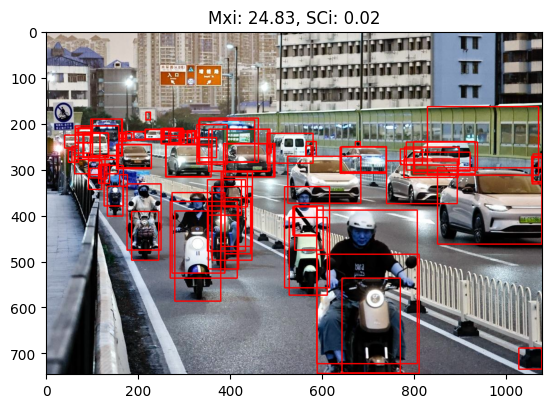

In [ ]:
import torch
from torchvision import models, transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1. 加载预训练的Mask R-CNN模型
model = models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()  # 设置为评估模式

# 2. 加载图像并进行预处理
def preprocess_image(image_path):
    image = cv2.imread(image_path)  # 读取图像
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # 转换为RGB格式
    transform = transforms.Compose([transforms.ToTensor()])  # 归一化
    image_tensor = transform(image_rgb)  # 转换为tensor
    image_tensor = image_tensor.unsqueeze(0)  # 添加批处理维度
    return image, image_tensor

# 3. 执行目标检测和实例分割
def detect_objects(image_path):
    image, image_tensor = preprocess_image(image_path)
    with torch.no_grad():  # 禁用梯度计算，减少内存消耗
        prediction = model(image_tensor)  # 进行推断
    return image, prediction

# 4. 计算目标间的最小距离并优化混行严重度（Mxi）
def calculate_mxi(boxes):
    """
    计算图像中目标的混行严重度（Mxi），基于目标边界框的中心点间距离。
    """
    centers = [( (box[0] + box[2]) / 2, (box[1] + box[3]) / 2) for box in boxes] # 完整的列表推导式
    distances = []

    # 计算每对目标的中心点之间的欧几里得距离
    for i in range(len(centers)):
        for j in range(i + 1, len(centers)):
            dist = np.linalg.norm(np.array(centers[i]) - np.array(centers[j]))  # 计算欧几里得距离
            distances.append(dist)

    # 计算最小距离的倒数作为混行严重度的优化
    if distances:
        min_distance = min(distances)  # 找到最小距离
        mxi = 1 / min_distance if min_distance > 0 else float('inf')  # 防止除零错误
        return mxi
    else:
        return 0  # 如果没有目标，返回0

# 5. 计算空间拥堵度（SCi）
def calculate_sci(boxes):
    """
    计算空间拥堵度（SCi），基于目标框的重叠度。
    """
    iou_list = []

    # 计算所有目标框之间的IoU
    for i in range(len(boxes)):
        for j in range(i + 1, len(boxes)):
            iou = calculate_iou(boxes[i], boxes[j])  # 计算IoU
            iou_list.append(iou)

    # 计算平均IoU作为空间拥堵度
    if iou_list:
        sci = np.mean(iou_list)
        return sci
    else:
        return 0  # 如果没有重叠，返回0

# 6. 计算边界框的IoU（Intersection over Union）
def calculate_iou(box1, box2):
    """
    计算两个边界框的IoU。
    """
    # 计算交集区域
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    # 计算交集区域的面积
    intersection_area = max(0, x2 - x1) * max(0, y2 - y1)

    # 计算两个框的并集区域面积
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - intersection_area

    # 计算IoU
    iou = intersection_area / union_area if union_area != 0 else 0
    return iou

# 7. 可视化目标检测结果和计算的混行严重度与空间拥堵度
def visualize_results(image, prediction):
    boxes = prediction[0]['boxes'].cpu().numpy()  # 获取目标框
    labels = prediction[0]['labels'].cpu().numpy()  # 获取标签
    scores = prediction[0]['scores'].cpu().numpy()  # 获取置信度

    # 可视化目标框
    for box in boxes:
        cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (255, 0, 0), 2)

    # 计算并输出混行严重度和空间拥堵度
    mxi = calculate_mxi(boxes)
    sci = calculate_sci(boxes)

    print(f"混行严重度（Mxi）：{mxi}")
    print(f"空间拥堵度（SCi）：{sci}")

    # 展示图像
    plt.imshow(image)
    plt.title(f"Mxi: {mxi:.2f}, SCi: {sci:.2f}")
    plt.show()

# 运行示例
image_path = 'Photo3.jpg'  # 替换为你图像的路径
image, prediction = detect_objects(image_path)
visualize_results(image, prediction)

混行严重度（Mxi）：0.5422177267285391
空间拥堵度（SCi）：0.0035276052981351664


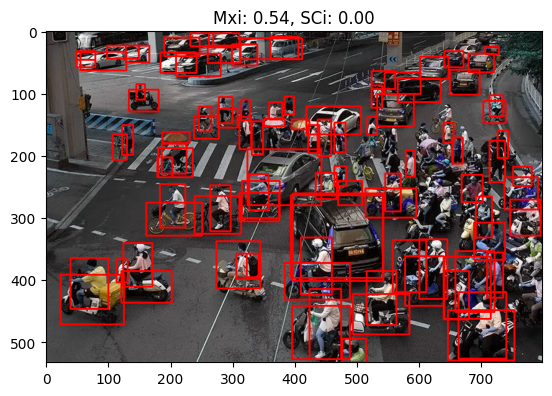

In [ ]:
import torch
from torchvision import models, transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1. 加载预训练的Mask R-CNN模型
model = models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()  # 设置为评估模式

# 2. 加载图像并进行预处理
def preprocess_image(image_path):
    image = cv2.imread(image_path)  # 读取图像
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # 转换为RGB格式
    transform = transforms.Compose([transforms.ToTensor()])  # 归一化
    image_tensor = transform(image_rgb)  # 转换为tensor
    image_tensor = image_tensor.unsqueeze(0)  # 添加批处理维度
    return image, image_tensor

# 3. 执行目标检测和实例分割
def detect_objects(image_path):
    image, image_tensor = preprocess_image(image_path)
    with torch.no_grad():  # 禁用梯度计算，减少内存消耗
        prediction = model(image_tensor)  # 进行推断
    return image, prediction

# 4. 计算目标间的最小距离并优化混行严重度（Mxi）
def calculate_mxi(boxes):
    """
    计算图像中目标的混行严重度（Mxi），基于目标边界框的中心点间距离。
    """
    centers = [( (box[0] + box[2]) / 2, (box[1] + box[3]) / 2) for box in boxes] # 完整的列表推导式
    distances = []

    # 计算每对目标的中心点之间的欧几里得距离
    for i in range(len(centers)):
        for j in range(i + 1, len(centers)):
            dist = np.linalg.norm(np.array(centers[i]) - np.array(centers[j]))  # 计算欧几里得距离
            distances.append(dist)

    # 计算最小距离的倒数作为混行严重度的优化
    if distances:
        min_distance = min(distances)  # 找到最小距离
        mxi = 1 / min_distance if min_distance > 0 else float('inf')  # 防止除零错误
        return mxi
    else:
        return 0  # 如果没有目标，返回0

# 5. 计算空间拥堵度（SCi）
def calculate_sci(boxes):
    """
    计算空间拥堵度（SCi），基于目标框的重叠度。
    """
    iou_list = []

    # 计算所有目标框之间的IoU
    for i in range(len(boxes)):
        for j in range(i + 1, len(boxes)):
            iou = calculate_iou(boxes[i], boxes[j])  # 计算IoU
            iou_list.append(iou)

    # 计算平均IoU作为空间拥堵度
    if iou_list:
        sci = np.mean(iou_list)
        return sci
    else:
        return 0  # 如果没有重叠，返回0

# 6. 计算边界框的IoU（Intersection over Union）
def calculate_iou(box1, box2):
    """
    计算两个边界框的IoU。
    """
    # 计算交集区域
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    # 计算交集区域的面积
    intersection_area = max(0, x2 - x1) * max(0, y2 - y1)

    # 计算两个框的并集区域面积
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - intersection_area

    # 计算IoU
    iou = intersection_area / union_area if union_area != 0 else 0
    return iou

# 7. 可视化目标检测结果和计算的混行严重度与空间拥堵度
def visualize_results(image, prediction):
    boxes = prediction[0]['boxes'].cpu().numpy()  # 获取目标框
    labels = prediction[0]['labels'].cpu().numpy()  # 获取标签
    scores = prediction[0]['scores'].cpu().numpy()  # 获取置信度

    # 可视化目标框
    for box in boxes:
        cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (255, 0, 0), 2)

    # 计算并输出混行严重度和空间拥堵度
    mxi = calculate_mxi(boxes)
    sci = calculate_sci(boxes)

    print(f"混行严重度（Mxi）：{mxi}")
    print(f"空间拥堵度（SCi）：{sci}")

    # 展示图像
    plt.imshow(image)
    plt.title(f"Mxi: {mxi:.2f}, SCi: {sci:.2f}")
    plt.show()

# 运行示例
image_path = 'Photo2.jpg'  # 替换为你图像的路径
image, prediction = detect_objects(image_path)
visualize_results(image, prediction)

In [ ]:
#Correct
import torch
from torchvision import models, transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1. 加载预训练的Mask R-CNN模型
model = models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()  # 设置为评估模式

# 2. 加载图像并进行预处理
def preprocess_image(image_path):
    image = cv2.imread(image_path)  # 读取图像
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # 转换为RGB格式
    transform = transforms.Compose([transforms.ToTensor()])  # 归一化
    image_tensor = transform(image_rgb)  # 转换为tensor
    image_tensor = image_tensor.unsqueeze(0)  # 添加批处理维度
    return image, image_tensor

# 3. 执行目标检测和实例分割
def detect_objects(image_path):
    image, image_tensor = preprocess_image(image_path)
    with torch.no_grad():  # 禁用梯度计算，减少内存消耗
        prediction = model(image_tensor)  # 进行推断
    return image, prediction

# 4. 计算目标间的最小距离
def calculate_min_distance(boxes):
    min_distance = float('inf')
    centers = [( (box[0] + box[2]) / 2, (box[1] + box[3]) / 2) for box in boxes]  # 正确的部分

    for i in range(len(centers)):
        for j in range(i + 1, len(centers)):
            dist = np.linalg.norm(np.array(centers[i]) - np.array(centers[j]))
            min_distance = min(min_distance, dist)

    return min_distance

# 5. 计算空间拥堵度（SCi）
def calculate_space_congestion(image, boxes, grid_size=(50, 50)):
    """
    计算空间拥堵度：
    1. 将图像划分为多个小网格。
    2. 计算每个网格中的目标密度。
    3. 用密度和目标重叠度来计算空间拥堵度。
    """
    height, width, _ = image.shape
    num_grids_x = width // grid_size[0]
    num_grids_y = height // grid_size[1]

    grid_counts = np.zeros((num_grids_y, num_grids_x))
    for box in boxes:
        x1, y1, x2, y2 = box
        grid_x1, grid_y1 = int(x1 // grid_size[0]), int(y1 // grid_size[1])
        grid_x2, grid_y2 = int(x2 // grid_size[0]), int(y2 // grid_size[1])
        grid_counts[grid_y1:grid_y2+1, grid_x1:grid_x2+1] += 1  # 增加对应区域内的目标数量

    # 计算目标密度的平均值
    total_density = grid_counts.sum() / (num_grids_x * num_grids_y)

    # 使用密度作为空间拥堵度的一个因素
    congestion_score = total_density / np.max(grid_counts)
    return congestion_score

# 6. 计算混行严重度（Mxi）
def calculate_mxi(boxes):
    min_distance = calculate_min_distance(boxes)  # 计算目标间的最小距离
    # 用最小距离来计算混行严重度
    return 1 / min_distance if min_distance > 0 else float('inf')

# 7. 主程序
def analyze_image(image_path):
    image, prediction = detect_objects(image_path)
    boxes = prediction[0]['boxes'].cpu().numpy()  # 获取所有检测到的目标框

    # 计算空间拥堵度和混行严重度
    sc = calculate_space_congestion(image, boxes)
    mxi = calculate_mxi(boxes)

    print(f"空间拥堵度（SCi）: {sc}")
    print(f"混行严重度（Mxi）: {mxi}")

    return sc, mxi

# 调用分析
image_path = 'Road2.png'  # 替换为实际的图像路径
analyze_image(image_path)

空间拥堵度（SCi）: 0.06898219814241487
混行严重度（Mxi）: 12.908584006978852


(0.06898219814241487, 12.908584006978852)

In [ ]:
#Correct
import torch
from torchvision import models, transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1. 加载预训练的Mask R-CNN模型
model = models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()  # 设置为评估模式

# 2. 加载图像并进行预处理
def preprocess_image(image_path):
    image = cv2.imread(image_path)  # 读取图像
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # 转换为RGB格式
    transform = transforms.Compose([transforms.ToTensor()])  # 归一化
    image_tensor = transform(image_rgb)  # 转换为tensor
    image_tensor = image_tensor.unsqueeze(0)  # 添加批处理维度
    return image, image_tensor

# 3. 执行目标检测和实例分割
def detect_objects(image_path):
    image, image_tensor = preprocess_image(image_path)
    with torch.no_grad():  # 禁用梯度计算，减少内存消耗
        prediction = model(image_tensor)  # 进行推断
    return image, prediction

# 4. 计算目标间的最小距离
def calculate_min_distance(boxes):
    min_distance = float('inf')
    centers = [( (box[0] + box[2]) / 2, (box[1] + box[3]) / 2) for box in boxes]  # 正确的部分

    for i in range(len(centers)):
        for j in range(i + 1, len(centers)):
            dist = np.linalg.norm(np.array(centers[i]) - np.array(centers[j]))
            min_distance = min(min_distance, dist)

    return min_distance

# 5. 计算空间拥堵度（SCi）
def calculate_space_congestion(image, boxes, grid_size=(50, 50)):
    """
    计算空间拥堵度：
    1. 将图像划分为多个小网格。
    2. 计算每个网格中的目标密度。
    3. 用密度和目标重叠度来计算空间拥堵度。
    """
    height, width, _ = image.shape
    num_grids_x = width // grid_size[0]
    num_grids_y = height // grid_size[1]

    grid_counts = np.zeros((num_grids_y, num_grids_x))
    for box in boxes:
        x1, y1, x2, y2 = box
        grid_x1, grid_y1 = int(x1 // grid_size[0]), int(y1 // grid_size[1])
        grid_x2, grid_y2 = int(x2 // grid_size[0]), int(y2 // grid_size[1])
        grid_counts[grid_y1:grid_y2+1, grid_x1:grid_x2+1] += 1  # 增加对应区域内的目标数量

    # 计算目标密度的平均值
    total_density = grid_counts.sum() / (num_grids_x * num_grids_y)

    # 使用密度作为空间拥堵度的一个因素
    congestion_score = total_density / np.max(grid_counts)
    return congestion_score

# 6. 计算混行严重度（Mxi）
def calculate_mxi(boxes):
    min_distance = calculate_min_distance(boxes)  # 计算目标间的最小距离
    # 用最小距离来计算混行严重度
    return 1 / min_distance if min_distance > 0 else float('inf')

# 7. 主程序
def analyze_image(image_path):
    image, prediction = detect_objects(image_path)
    boxes = prediction[0]['boxes'].cpu().numpy()  # 获取所有检测到的目标框

    # 计算空间拥堵度和混行严重度
    sc = calculate_space_congestion(image, boxes)
    mxi = calculate_mxi(boxes)

    print(f"空间拥堵度（SCi）: {sc}")
    print(f"混行严重度（Mxi）: {mxi}")

    return sc, mxi

# 调用分析
image_path = 'Photo2.jpg'  # 替换为实际的图像路径
analyze_image(image_path)

空间拥堵度（SCi）: 0.42111111111111116
混行严重度（Mxi）: 0.5422177267285391


(0.42111111111111116, 0.5422177267285391)

Mxi 和 SCi 是两种衡量图像中目标之间关系的度量，它们的值越大，表示不同的含义，下面是对它们的详细解释：

1. 空间拥堵度（SCi）
SCi 衡量的是图像中目标之间的空间拥挤程度，通常是通过计算目标之间的重叠度（如 IoU，交并比）来评估。

SCi 越大，表示目标之间的重叠度越高，目标之间的距离越近，意味着 空间越拥挤。在这种情况下，可能发生目标的遮挡、相互干扰等情况。

解释：

SCi = 0.0：没有重叠，目标之间完全分离。
SCi 越大，表示目标的边界框重叠越来越多，空间变得更加拥挤。
高 SCi 值的含义：

在一些场景中，SCi 值较高 可能意味着目标之间的区域重叠过大，导致视觉上更拥挤，可能影响识别和追踪效果。例如，在高密度的交通场景或人群中，目标重叠严重，拥堵指数较高。
2. 混行严重度（Mxi）
Mxi 衡量的是目标之间的最小距离，通常反映目标之间是否发生了混行或相互接近。

Mxi 越大，表示目标之间的最小距离越大，意味着目标之间 越分散，没有发生混行或交叠。

解释：

Mxi = 0.0：目标完全重叠或接触，表示混行严重。
Mxi 越大，表示目标之间的距离增加，混行程度降低。
高 Mxi 值的含义：

Mxi 值较大 说明目标彼此之间的距离较远，混行问题较轻。例如，在较为空旷或分散的环境中，目标之间有更多的空间，互相干扰较少。

In [ ]:
#Correct
import torch
from torchvision import models, transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1. 加载预训练的Mask R-CNN模型
model = models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()  # 设置为评估模式

# 2. 加载图像并进行预处理
def preprocess_image(image_path):
    image = cv2.imread(image_path)  # 读取图像
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # 转换为RGB格式
    transform = transforms.Compose([transforms.ToTensor()])  # 归一化
    image_tensor = transform(image_rgb)  # 转换为tensor
    image_tensor = image_tensor.unsqueeze(0)  # 添加批处理维度
    return image, image_tensor

# 3. 执行目标检测和实例分割
def detect_objects(image_path):
    image, image_tensor = preprocess_image(image_path)
    with torch.no_grad():  # 禁用梯度计算，减少内存消耗
        prediction = model(image_tensor)  # 进行推断
    return image, prediction

# 4. 计算目标间的最小距离
def calculate_min_distance(boxes):
    min_distance = float('inf')
    centers = [( (box[0] + box[2]) / 2, (box[1] + box[3]) / 2) for box in boxes]  # 正确的部分

    for i in range(len(centers)):
        for j in range(i + 1, len(centers)):
            dist = np.linalg.norm(np.array(centers[i]) - np.array(centers[j]))
            min_distance = min(min_distance, dist)

    return min_distance

# 5. 计算空间拥堵度（SCi）
def calculate_space_congestion(image, boxes, grid_size=(50, 50)):
    """
    计算空间拥堵度：
    1. 将图像划分为多个小网格。
    2. 计算每个网格中的目标密度。
    3. 用密度和目标重叠度来计算空间拥堵度。
    """
    height, width, _ = image.shape
    num_grids_x = width // grid_size[0]
    num_grids_y = height // grid_size[1]

    grid_counts = np.zeros((num_grids_y, num_grids_x))
    for box in boxes:
        x1, y1, x2, y2 = box
        grid_x1, grid_y1 = int(x1 // grid_size[0]), int(y1 // grid_size[1])
        grid_x2, grid_y2 = int(x2 // grid_size[0]), int(y2 // grid_size[1])
        grid_counts[grid_y1:grid_y2+1, grid_x1:grid_x2+1] += 1  # 增加对应区域内的目标数量

    # 计算目标密度的平均值
    total_density = grid_counts.sum() / (num_grids_x * num_grids_y)

    # 使用密度作为空间拥堵度的一个因素
    congestion_score = total_density / np.max(grid_counts)
    return congestion_score

# 6. 计算混行严重度（Mxi）
def calculate_mxi(boxes):
    min_distance = calculate_min_distance(boxes)  # 计算目标间的最小距离
    # 用最小距离来计算混行严重度
    return 1 / min_distance if min_distance > 0 else float('inf')

# 7. 主程序
def analyze_image(image_path):
    image, prediction = detect_objects(image_path)
    boxes = prediction[0]['boxes'].cpu().numpy()  # 获取所有检测到的目标框

    # 计算空间拥堵度和混行严重度
    sc = calculate_space_congestion(image, boxes)
    mxi = calculate_mxi(boxes)

    print(f"空间拥堵度（SCi）: {sc}")
    print(f"混行严重度（Mxi）: {mxi}")

    return sc, mxi

# 调用分析
image_path = 'Photo2.jpg'  # 替换为实际的图像路径
analyze_image(image_path)

空间拥堵度（SCi）: 0.42111111111111116
混行严重度（Mxi）: 0.5422177267285391


(0.42111111111111116, 0.5422177267285391)

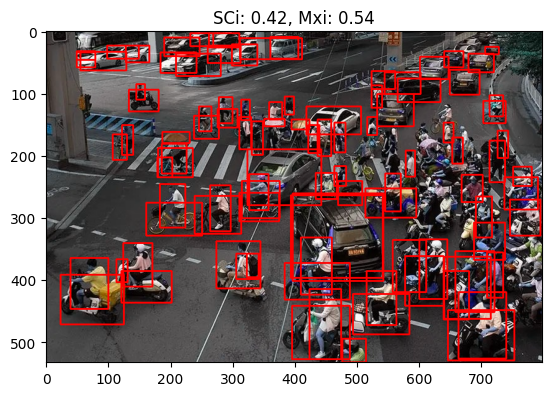

In [ ]:
import torch
from torchvision import models, transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1. 加载预训练的Mask R-CNN模型
model = models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()  # 设置为评估模式

# 2. 加载图像并进行预处理
def preprocess_image(image_path):
    image = cv2.imread(image_path)  # 读取图像
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # 转换为RGB格式
    transform = transforms.Compose([transforms.ToTensor()])  # 归一化
    image_tensor = transform(image_rgb)  # 转换为tensor
    image_tensor = image_tensor.unsqueeze(0)  # 添加批处理维度
    return image, image_tensor

# 3. 执行目标检测和实例分割
def detect_objects(image_path):
    image, image_tensor = preprocess_image(image_path)
    with torch.no_grad():  # 禁用梯度计算，减少内存消耗
        prediction = model(image_tensor)  # 执行预测
    return image, prediction

# 4. 可视化目标检测和实例分割的结果
def visualize_detection(image, prediction, sc, mxi):
    # 在图像上绘制目标的边界框
    for box in prediction[0]['boxes']:
        x1, y1, x2, y2 = box.cpu().numpy()
        cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)

    # 可视化掩码（如果有的话）
    #masks = prediction[0]['masks'].cpu().numpy()
    #for mask in masks:
        #mask = mask[0] > 0.5  # 将掩码二值化
        #image[mask] = [0, 255, 0]  # 用绿色标记掩码区域

    # 使用matplotlib显示图像
    plt.imshow(image)
    plt.title(f"SCi: {sc:.2f}, Mxi: {mxi:.2f}")
    plt.show()

# 假设你已经计算了 SCi 和 Mxi 的值
sc = 0.42  # 例如
mxi = 0.54  # 例如

# 示例图像路径
image_path = "Photo2.jpg"  # 替换为你的图像路径

# 检测目标并可视化结果
image, prediction = detect_objects(image_path)
visualize_detection(image, prediction, sc, mxi)


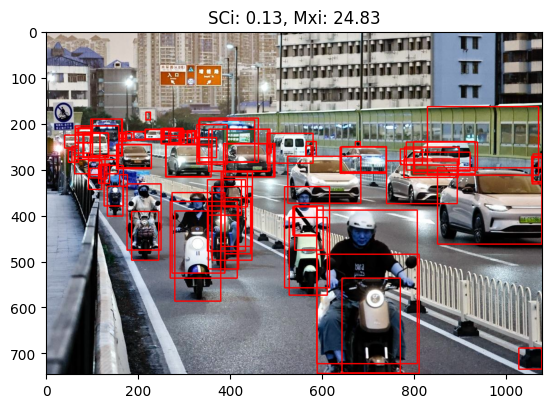

In [ ]:
import torch
from torchvision import models, transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1. 加载预训练的Mask R-CNN模型
model = models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()  # 设置为评估模式

# 2. 加载图像并进行预处理
def preprocess_image(image_path):
    image = cv2.imread(image_path)  # 读取图像
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # 转换为RGB格式
    transform = transforms.Compose([transforms.ToTensor()])  # 归一化
    image_tensor = transform(image_rgb)  # 转换为tensor
    image_tensor = image_tensor.unsqueeze(0)  # 添加批处理维度
    return image, image_tensor

# 3. 执行目标检测和实例分割
def detect_objects(image_path):
    image, image_tensor = preprocess_image(image_path)
    with torch.no_grad():  # 禁用梯度计算，减少内存消耗
        prediction = model(image_tensor)  # 执行预测
    return image, prediction

# 4. 可视化目标检测和实例分割的结果
def visualize_detection(image, prediction, sc, mxi):
    # 在图像上绘制目标的边界框
    for box in prediction[0]['boxes']:
        x1, y1, x2, y2 = box.cpu().numpy()
        cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)

    # 可视化掩码（如果有的话）
    #masks = prediction[0]['masks'].cpu().numpy()
    #for mask in masks:
        #mask = mask[0] > 0.5  # 将掩码二值化
        #image[mask] = [0, 255, 0]  # 用绿色标记掩码区域

    # 使用matplotlib显示图像
    plt.imshow(image)
    plt.title(f"SCi: {sc:.2f}, Mxi: {mxi:.2f}")
    plt.show()

# 假设你已经计算了 SCi 和 Mxi 的值
sc = 0.13  # 例如
mxi = 24.83  # 例如

# 示例图像路径
image_path = "Road2.png"  # 替换为你的图像路径

# 检测目标并可视化结果
image, prediction = detect_objects(image_path)
visualize_detection(image, prediction, sc, mxi)

In [ ]:
import torch
from torchvision import models, transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1. 加载预训练的Mask R-CNN模型
model = models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()  # 设置为评估模式

# 2. 加载图像并进行预处理
def preprocess_image(image_path):
    image = cv2.imread(image_path)  # 读取图像
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # 转换为RGB格式
    transform = transforms.Compose([transforms.ToTensor()])  # 归一化
    image_tensor = transform(image_rgb)  # 转换为tensor
    image_tensor = image_tensor.unsqueeze(0)  # 添加批处理维度
    return image, image_tensor

# 3. 执行目标检测和实例分割
def detect_objects(image_path):
    image, image_tensor = preprocess_image(image_path)
    with torch.no_grad():  # 禁用梯度计算，减少内存消耗
        prediction = model(image_tensor)  # 执行预测
    return image, prediction

# 4. 可视化目标检测和实例分割的结果
def visualize_detection(image, prediction, sc, mxi):
    # 在图像上绘制目标的边界框
    for box in prediction[0]['boxes']:
        x1, y1, x2, y2 = box.cpu().numpy()
        cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)

    # 可视化掩码（如果有的话）
    masks = prediction[0]['masks'].cpu().numpy()
    for mask in masks:
        mask = mask[0] > 0.5  # 将掩码二值化
        image[mask] = [0, 255, 0]  # 用绿色标记掩码区域

    # 使用matplotlib显示图像
    plt.imshow(image)
    #plt.title(f"SCi: {sc:.2f}, Mxi: {mxi:.2f}")
    plt.show()

# 假设你已经计算了 SCi 和 Mxi 的值
#sc = 0.42  # 例如
#mxi = 0.54  # 例如

# 示例图像路径
image_path = "Photo2.jpg"  # 替换为你的图像路径

# 检测目标并可视化结果
image, prediction = detect_objects(image_path)
visualize_detection(image, prediction)

In [ ]:
###VIDEO
import torch
from torchvision import models, transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1. 加载预训练的Mask R-CNN模型
model = models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()  # 设置为评估模式

# 2. 加载图像并进行预处理
def preprocess_image(image):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # 转换为RGB格式
    transform = transforms.Compose([transforms.ToTensor()])  # 归一化
    image_tensor = transform(image_rgb)  # 转换为tensor
    image_tensor = image_tensor.unsqueeze(0)  # 添加批处理维度
    return image_tensor

# 3. 执行目标检测和实例分割
def detect_objects(image):
    image_tensor = preprocess_image(image)
    with torch.no_grad():  # 禁用梯度计算，减少内存消耗
        prediction = model(image_tensor)  # 进行推断
    return prediction

# 4. 计算目标间的最小距离
def calculate_min_distance(boxes):
    min_distance = float('inf')
    centers = [((box[0] + box[2]) / 2, (box[1] + box[3]) / 2) for box in boxes]  # 计算中心点

    for i in range(len(centers)):
        for j in range(i + 1, len(centers)):
            dist = np.linalg.norm(np.array(centers[i]) - np.array(centers[j]))
            min_distance = min(min_distance, dist)

    return min_distance

# 5. 计算空间拥堵度（SCi）
def calculate_space_congestion(image, boxes, grid_size=(50, 50)):
    height, width, _ = image.shape
    num_grids_x = width // grid_size[0]
    num_grids_y = height // grid_size[1]

    grid_counts = np.zeros((num_grids_y, num_grids_x))
    for box in boxes:
        x1, y1, x2, y2 = box
        grid_x1, grid_y1 = int(x1 // grid_size[0]), int(y1 // grid_size[1])
        grid_x2, grid_y2 = int(x2 // grid_size[0]), int(y2 // grid_size[1])
        grid_counts[grid_y1:grid_y2+1, grid_x1:grid_x2+1] += 1  # 增加对应区域内的目标数量

    # 计算目标密度的平均值
    total_density = grid_counts.sum() / (num_grids_x * num_grids_y)

    # 使用密度作为空间拥堵度的一个因素
    congestion_score = total_density / np.max(grid_counts)
    return congestion_score

# 6. 计算混行严重度（Mxi）
def calculate_mxi(boxes):
    min_distance = calculate_min_distance(boxes)  # 计算目标间的最小距离
    # 用最小距离来计算混行严重度
    return 1 / min_distance if min_distance > 0 else float('inf')

# 7. 视频帧处理与指数提取
def analyze_video(video_path, output_path=None):
    cap = cv2.VideoCapture(video_path)
    frame_idx = 0
    results = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break  # 视频结束

        # 检测每帧的目标
        prediction = detect_objects(frame)
        boxes = prediction[0]['boxes'].cpu().numpy() if len(prediction[0]['boxes']) > 0 else []

        # 计算空间拥堵度和混行严重度
        sc = calculate_space_congestion(frame, boxes)
        mxi = calculate_mxi(boxes)

        results.append((frame_idx, sc, mxi))
        print(f"帧 {frame_idx}: 空间拥堵度（SCi）: {sc}, 混行严重度（Mxi）: {mxi}")

        frame_idx += 1

        # 可视化结果（可选）
        for box in boxes:
            x1, y1, x2, y2 = map(int, box)
            cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 0, 0), 2)

        if output_path:
            out.write(frame)  # 保存标注视频

    cap.release()
    if output_path:
        out.release()

    return results

# 主程序调用
video_path = 'videoplayback1.mp4'  # 替换为实际的视频路径
output_path = 'output_video.avi'  # 替换为实际输出路径，若不需要保存标注视频，可以设置为None

# 如果需要保存输出视频，初始化视频写入器
cap = cv2.VideoCapture(video_path)
if output_path:
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

cap.release()

# 运行视频分析
results = analyze_video(video_path, output_path)

# 保存结果
import pandas as pd
df = pd.DataFrame(results, columns=['Frame', 'SCi', 'Mxi'])
df.to_csv('results.csv', index=False)
print("结果已保存至results.csv")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:01<00:00, 146MB/s]


帧 0: 空间拥堵度（SCi）: 0.10346938775510205, 混行严重度（Mxi）: 12.91235772521001
帧 1: 空间拥堵度（SCi）: 0.13333333333333333, 混行严重度（Mxi）: 1.3455974879380952
帧 2: 空间拥堵度（SCi）: 0.1519047619047619, 混行严重度（Mxi）: 12.724541445151857
帧 3: 空间拥堵度（SCi）: 0.09371428571428571, 混行严重度（Mxi）: 3.6649033160166535
帧 4: 空间拥堵度（SCi）: 0.12095238095238096, 混行严重度（Mxi）: 24.733281212494454
帧 5: 空间拥堵度（SCi）: 0.10591836734693878, 混行严重度（Mxi）: 2.3215953811235335
帧 6: 空间拥堵度（SCi）: 0.15428571428571428, 混行严重度（Mxi）: 3.855272270117446
帧 7: 空间拥堵度（SCi）: 0.1392857142857143, 混行严重度（Mxi）: 3.358592549618626
帧 8: 空间拥堵度（SCi）: 0.14727272727272728, 混行严重度（Mxi）: 4.139551279415249
帧 9: 空间拥堵度（SCi）: 0.13, 混行严重度（Mxi）: 3.6681557553779345
帧 10: 空间拥堵度（SCi）: 0.16571428571428573, 混行严重度（Mxi）: 4.337346187546965
帧 11: 空间拥堵度（SCi）: 0.10857142857142857, 混行严重度（Mxi）: 3.5487414284729444
帧 12: 空间拥堵度（SCi）: 0.125, 混行严重度（Mxi）: 2.8311413317710485
帧 13: 空间拥堵度（SCi）: 0.128, 混行严重度（Mxi）: 2.5693808667947264
帧 14: 空间拥堵度（SCi）: 0.12775510204081633, 混行严重度（Mxi）: 3.3295656610130826
帧 15: 空间拥堵

In [ ]:
### VIDEO ANALYSIS CODE ALL indices

import torch
from torchvision import models, transforms
import cv2
import numpy as np
import pandas as pd

#######################
# 1. 加载预训练的 Mask R-CNN 模型
#######################
model = models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()  # 设置为推理模式

#######################
# 2. 预处理函数
#######################
def preprocess_image(image):
    # 转换为 RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # 构建预处理变换（仅 ToTensor，可添加其他如 Resize、Normalize 等）
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    image_tensor = transform(image_rgb)
    # 增加一个批量维度 (1, C, H, W)
    image_tensor = image_tensor.unsqueeze(0)
    return image_tensor

#######################
# 3. 目标检测函数
#######################
@torch.no_grad()  # 禁用梯度计算，减少内存消耗
def detect_objects(image):
    image_tensor = preprocess_image(image)
    prediction = model(image_tensor)
    return prediction

#######################
# 4. 指标计算相关函数
#######################

def calculate_min_distance(boxes):
    """
    计算一帧中所有目标之间的最小距离
    boxes: [N, 4], 每个box格式 [x1, y1, x2, y2]
    返回值: float, 该帧所有目标中心点之间的最小欧几里得距离
    """
    min_distance = float('inf')
    centers = [((box[0] + box[2]) / 2, (box[1] + box[3]) / 2) for box in boxes]

    for i in range(len(centers)):
        for j in range(i + 1, len(centers)):
            dist = np.linalg.norm(np.array(centers[i]) - np.array(centers[j]))
            if dist < min_distance:
                min_distance = dist

    return min_distance if len(centers) > 1 else float('inf')

def calculate_space_congestion(image, boxes, grid_size=(50, 50)):
    """
    计算空间拥堵度 (SCi)
    :param image: 当前帧图像 (H, W, 3)
    :param boxes: 检测到的目标边界框列表
    :param grid_size: 网格大小
    :return: 一个拥堵度分数 (float)
    """
    height, width, _ = image.shape
    num_grids_x = width // grid_size[0]
    num_grids_y = height // grid_size[1]

    if num_grids_x == 0 or num_grids_y == 0:
        return 0  # 防止极小图像或 grid_size 过大导致报错

    grid_counts = np.zeros((num_grids_y, num_grids_x))
    for box in boxes:
        x1, y1, x2, y2 = box
        grid_x1, grid_y1 = int(x1 // grid_size[0]), int(y1 // grid_size[1])
        grid_x2, grid_y2 = int(x2 // grid_size[0]), int(y2 // grid_size[1])
        # 限制索引边界
        grid_x1 = max(0, grid_x1)
        grid_y1 = max(0, grid_y1)
        grid_x2 = min(num_grids_x - 1, grid_x2)
        grid_y2 = min(num_grids_y - 1, grid_y2)
        grid_counts[grid_y1:grid_y2+1, grid_x1:grid_x2+1] += 1

    total_density = grid_counts.sum() / (num_grids_x * num_grids_y)
    max_count = np.max(grid_counts)
    if max_count == 0:
        return 0  # 若整帧都无目标，则拥堵度为0

    congestion_score = total_density / max_count
    return congestion_score

def calculate_mxi(boxes):
    """
    计算混行严重度(Mxi) = 1 / min_distance
    :param boxes: 同上
    """
    min_distance = calculate_min_distance(boxes)
    return 1 / min_distance if min_distance > 0 and min_distance != float('inf') else 0

def calculate_visual_complexity(frame):
    """
    使用灰度图的熵(Entropy)来度量视觉复杂度。
    熵值越高表示图像纹理或信息越丰富，视觉复杂度更大。
    """
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
    hist_norm = hist.ravel() / hist.sum()

    epsilon = 1e-7  # 避免log(0)
    entropy = -np.sum(hist_norm * np.log2(hist_norm + epsilon))
    return entropy

def compute_time_conflict_frequency(min_distances, threshold, fps):
    """
    根据视频中各帧的最小距离列表, 计算近距冲突事件在单位时间内的频次.
    :param min_distances: [dist_frame0, dist_frame1, ...]
    :param threshold: 阈值(像素或实际单位), 小于此值则视为潜在冲突
    :param fps: 帧率
    :return: 冲突事件每秒发生频次 conflicts_per_second
    """
    conflict_count = sum(1 for dist in min_distances if dist < threshold)

    total_frames = len(min_distances)
    total_seconds = total_frames / fps if fps > 0 else 1e-6
    conflicts_per_second = conflict_count / total_seconds
    return conflicts_per_second

#######################
# 5. 视频分析主程序
#######################
def analyze_video(video_path, output_path=None, distance_threshold=50):
    """
    分析视频, 输出每帧的 SCi, Mxi, Visual Complexity 以及最终的近距冲突频次.
    :param video_path: 输入视频路径
    :param output_path: 保存带检测结果的视频(可选)
    :param distance_threshold: 近距冲突的距离阈值(像素单位), 默认50
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"无法打开视频: {video_path}")
        return

    # 若需要保存视频, 初始化输出
    writer = None
    if output_path:
        fourcc = cv2.VideoWriter_fourcc(*'XVID')
        fps = cap.get(cv2.CAP_PROP_FPS)
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        writer = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    else:
        fps = cap.get(cv2.CAP_PROP_FPS)

    frame_idx = 0
    results = []
    min_distance_list = []  # 用于后续计算近距冲突频次

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        prediction = detect_objects(frame)
        boxes = prediction[0]['boxes'].cpu().numpy() if len(prediction[0]['boxes']) else []

        # 计算各指标
        sc = calculate_space_congestion(frame, boxes)
        mxi = calculate_mxi(boxes)
        v_complex = calculate_visual_complexity(frame)

        # 当前帧的最小距离 (用于后续计算冲突频次)
        current_min_dist = calculate_min_distance(boxes)
        min_distance_list.append(current_min_dist)

        # 保存结果
        results.append((frame_idx, sc, mxi, v_complex))
        print(f"帧{frame_idx}: SCi={sc:.3f}, Mxi={mxi:.3f}, VisualComplex={v_complex:.3f}, MinDist={current_min_dist:.3f}")

        # 可视化(可选)
        for box in boxes:
            x1, y1, x2, y2 = map(int, box)
            cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 0, 0), 2)

        # 保存视频
        if writer is not None:
            writer.write(frame)

        frame_idx += 1

    cap.release()
    if writer is not None:
        writer.release()

    # 根据 min_distance_list 计算整段视频的近距冲突频次
    near_conflict_freq = compute_time_conflict_frequency(min_distance_list, distance_threshold, fps)
    print(f"近距冲突频次: {near_conflict_freq:.3f} 次/秒 (Threshold={distance_threshold} px)")

    # 结果保存到CSV
    df = pd.DataFrame(results, columns=['Frame', 'SCi', 'Mxi', 'VisualComplex'])
    # 在CSV中无法逐帧记录 near_conflict_freq(它是整段视频的一个值)
    # 可以在CSV末尾加一行, 或单独打印即可
    df.to_csv('results.csv', index=False)
    print("帧级指标(SCi, Mxi, VisualComplex)已保存至 results.csv")

    return df, near_conflict_freq

#############
# 运行示例
#############
if __name__ == "__main__":
    video_path = 'videoplayback1.mp4'  # 替换为实际视频路径
    output_path = 'output_video.avi'  # 如不需要保存可设为 None

    df, near_conflicts = analyze_video(video_path, output_path, distance_threshold=50)
    print("Video analysis completed.")
    print("Near-conflict frequency:", near_conflicts)

In [ ]:
import torch
from torchvision import models, transforms
import cv2
import numpy as np
import pandas as pd

#######################
# 1. 加载预训练的 Mask R-CNN 模型
#######################
model = models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

#######################
# 2. 预处理
#######################
def preprocess_image(image):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    transform_fn = transforms.Compose([
        transforms.ToTensor()
    ])
    image_tensor = transform_fn(image_rgb).unsqueeze(0)  # (1, C, H, W)
    return image_tensor

#######################
# 3. 目标检测
#######################
@torch.no_grad()
def detect_objects(image):
    image_tensor = preprocess_image(image)
    prediction = model(image_tensor)
    return prediction

#######################
# 4. 指标计算函数
#######################
def calculate_min_distance(boxes):
    """
    计算所有目标之间的最小距离
    boxes: [N, 4] => [x1, y1, x2, y2]
    """
    if len(boxes) < 2:
        return float('inf')

    centers = [((b[0] + b[2]) / 2, (b[1] + b[3]) / 2) for b in boxes]
    min_dist = float('inf')
    for i in range(len(centers)):
        for j in range(i + 1, len(centers)):
            dist = np.linalg.norm(np.array(centers[i]) - np.array(centers[j]))
            if dist < min_dist:
                min_dist = dist
    return min_dist

def calculate_space_congestion(image, boxes, grid_size=(50,50)):
    """
    空间拥堵度 (SCi)
    """
    height, width, _ = image.shape
    num_grids_x = width // grid_size[0]
    num_grids_y = height // grid_size[1]
    if num_grids_x == 0 or num_grids_y == 0:
        return 0

    grid_counts = np.zeros((num_grids_y, num_grids_x))
    for box in boxes:
        x1, y1, x2, y2 = box
        gx1, gy1 = int(x1 // grid_size[0]), int(y1 // grid_size[1])
        gx2, gy2 = int(x2 // grid_size[0]), int(y2 // grid_size[1])

        gx1 = max(0, gx1)
        gy1 = max(0, gy1)
        gx2 = min(num_grids_x - 1, gx2)
        gy2 = min(num_grids_y - 1, gy2)

        grid_counts[gy1:gy2+1, gx1:gx2+1] += 1

    total_density = grid_counts.sum() / (num_grids_x * num_grids_y)
    max_count = np.max(grid_counts)
    if max_count == 0:
        return 0

    congestion_score = total_density / max_count
    return congestion_score

def calculate_mxi(boxes):
    """
    混行严重度(Mxi) = 1 / min_dist
    """
    min_dist = calculate_min_distance(boxes)
    if min_dist > 0 and min_dist != float('inf'):
        return 1 / min_dist
    else:
        return 0

def calculate_visual_complexity(frame):
    """
    使用灰度图熵(Entropy)衡量视觉复杂度
    """
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    hist = cv2.calcHist([gray], [0], None, [256], [0,256])
    hist_norm = hist.ravel() / hist.sum()
    epsilon = 1e-7
    entropy = -np.sum(hist_norm * np.log2(hist_norm + epsilon))
    return entropy

def compute_time_conflict_frequency(min_distances, threshold, time_interval=2.0):
    """
    在多帧(多张图片)的场景下, 计算近距冲突事件的每秒频次.
    :param min_distances: [dist_frame0, dist_frame1, ...]
    :param threshold: 小于此距离 => 冲突事件
    :param time_interval: 帧间隔(秒), 若3张图, total_time = (3-1)*time_interval
    """
    conflict_count = sum(1 for dist in min_distances if dist < threshold)

    n_frames = len(min_distances)
    if n_frames > 1:
        total_seconds = (n_frames - 1) * time_interval
    else:
        # 只有1帧时, 可视为 time_interval 秒, 自定义处理
        total_seconds = time_interval

    conflicts_per_second = conflict_count / total_seconds if total_seconds > 0 else 0
    return conflicts_per_second

#######################
# 5. 主函数: 多张图片模拟时间序列
#######################
def analyze_images_as_time_sequence(image_paths, distance_threshold=50, time_interval=2.0):
    """
    给定多张图片, 假设它们在 time_interval(秒) 间隔拍摄,
    计算并输出 SCi, Mxi, VisualComplex, 以及整段时间的Near-Conflict Frequency.
    :param image_paths: [img1, img2, img3, ...]
    :param distance_threshold: 近距冲突阈值
    :param time_interval: 帧间隔
    """
    results = []
    min_distances = []

    for idx, img_path in enumerate(image_paths):
        frame = cv2.imread(img_path)
        if frame is None:
            print(f"无法读取图像 {img_path}")
            continue

        # 目标检测
        prediction = detect_objects(frame)
        boxes = prediction[0]['boxes'].cpu().numpy() if len(prediction[0]['boxes']) else []

        # 计算指标
        sc = calculate_space_congestion(frame, boxes)
        mxi = calculate_mxi(boxes)
        vc = calculate_visual_complexity(frame)
        min_dist = calculate_min_distance(boxes)

        min_distances.append(min_dist)

        print(f"Frame {idx} ({img_path}):")
        print(f"  SCi={sc:.3f}, Mxi={mxi:.3f}, VisualComplex={vc:.3f}, MinDist={min_dist:.3f}")

        results.append((idx, img_path, sc, mxi, vc, min_dist))

    # 计算多帧时间冲突频次
    near_conflict_freq = compute_time_conflict_frequency(min_distances, distance_threshold, time_interval)
    print(f"\n=== 多张图像近距冲突频次: {near_conflict_freq:.3f} 次/秒 (threshold={distance_threshold}, interval={time_interval}s) ===")

    # 保存到CSV
    df = pd.DataFrame(results, columns=['Frame', 'ImagePath', 'SCi', 'Mxi', 'VisualComplex', 'MinDist'])
    df.to_csv('multiple_images_results.csv', index=False)
    print("结果已保存: multiple_images_results.csv")

    return df, near_conflict_freq

#######################
# 6. 使用示例
#######################
if __name__ == "__main__":
    # 假设有三张图片, 间隔2秒
    image_list = [
        "Road2.png",
        "Road3.png",
        "Road4.png"
    ]

    # 运行分析
    df, conflict_per_second = analyze_images_as_time_sequence(
        image_paths=image_list,
        distance_threshold=50,     # 根据分辨率或实际场景调整
        time_interval=2.0         # 2秒间隔
    )

    print("\n分析结束.")
    print(df)
    print("近距冲突频次(次/秒):", conflict_per_second)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Frame 0 (Road2.png):
  SCi=0.069, Mxi=12.909, VisualComplex=7.817, MinDist=0.077
Frame 1 (Road3.png):
  SCi=0.071, Mxi=2.699, VisualComplex=7.787, MinDist=0.371
Frame 2 (Road4.png):
  SCi=0.096, Mxi=4.267, VisualComplex=7.842, MinDist=0.234

=== 多张图像近距冲突频次: 0.750 次/秒 (threshold=50, interval=2.0s) ===
结果已保存: multiple_images_results.csv

分析结束.
   Frame  ImagePath       SCi        Mxi  VisualComplex   MinDist
0      0  Road2.png  0.068982  12.908584       7.816743  0.077468
1      1  Road3.png  0.070530   2.698940       7.787105  0.370516
2      2  Road4.png  0.095553   4.267073       7.842158  0.234353
近距冲突频次(次/秒): 0.75


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


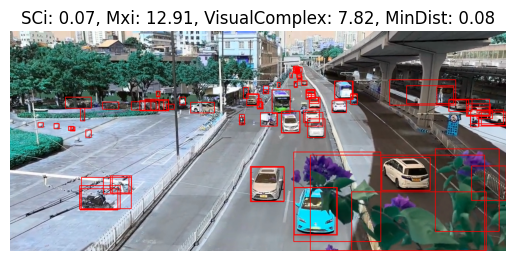

In [ ]:
import torch
from torchvision import models, transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1. 加载预训练的Mask R-CNN模型
model = models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()  # 设置为评估模式

# 2. 加载图像并进行预处理
def preprocess_image(image_path):
    image = cv2.imread(image_path)  # 读取图像
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # 转换为RGB格式
    transform = transforms.Compose([transforms.ToTensor()])  # 归一化
    image_tensor = transform(image_rgb)  # 转换为tensor
    image_tensor = image_tensor.unsqueeze(0)  # 添加批处理维度
    return image, image_tensor

# 3. 执行目标检测和实例分割
def detect_objects(image_path):
    image, image_tensor = preprocess_image(image_path)
    with torch.no_grad():  # 禁用梯度计算，减少内存消耗
        prediction = model(image_tensor)  # 执行预测
    return image, prediction

# 4. 可视化目标检测和实例分割的结果
def visualize_detection(image, prediction, sc, mxi, visualcomplex, mindist):
    # 在图像上绘制目标的边界框
    for box in prediction[0]['boxes']:
        x1, y1, x2, y2 = box.cpu().numpy()
        cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)

    # 使用matplotlib显示图像
    plt.imshow(image)
    plt.title(f"SCi: {sc:.2f}, Mxi: {mxi:.2f}, VisualComplex: {visualcomplex:.2f}, MinDist: {mindist:.2f}")
    plt.axis('off')  # 隐藏坐标轴
    plt.show()

# 假设你已经计算了 SCi、Mxi、VisualComplex 和 MinDist 的值
sc = 0.07  # 示例值
mxi = 12.91  # 示例值
visualcomplex = 7.82  # 示例值
mindist = 0.08  # 示例值

# 示例图像路径
image_path = "Road2.png"  # 替换为你的图像路径

# 检测目标并可视化结果
image, prediction = detect_objects(image_path)
visualize_detection(image, prediction, sc, mxi, visualcomplex, mindist)

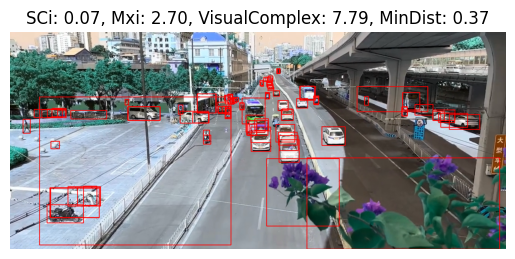

In [ ]:
import torch
from torchvision import models, transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1. 加载预训练的Mask R-CNN模型
model = models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()  # 设置为评估模式

# 2. 加载图像并进行预处理
def preprocess_image(image_path):
    image = cv2.imread(image_path)  # 读取图像
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # 转换为RGB格式
    transform = transforms.Compose([transforms.ToTensor()])  # 归一化
    image_tensor = transform(image_rgb)  # 转换为tensor
    image_tensor = image_tensor.unsqueeze(0)  # 添加批处理维度
    return image, image_tensor

# 3. 执行目标检测和实例分割
def detect_objects(image_path):
    image, image_tensor = preprocess_image(image_path)
    with torch.no_grad():  # 禁用梯度计算，减少内存消耗
        prediction = model(image_tensor)  # 执行预测
    return image, prediction

# 4. 可视化目标检测和实例分割的结果
def visualize_detection(image, prediction, sc, mxi, visualcomplex, mindist):
    # 在图像上绘制目标的边界框
    for box in prediction[0]['boxes']:
        x1, y1, x2, y2 = box.cpu().numpy()
        cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)

    # 使用matplotlib显示图像
    plt.imshow(image)
    plt.title(f"SCi: {sc:.2f}, Mxi: {mxi:.2f}, VisualComplex: {visualcomplex:.2f}, MinDist: {mindist:.2f}")
    plt.axis('off')  # 隐藏坐标轴
    plt.show()

# 假设你已经计算了 SCi、Mxi、VisualComplex 和 MinDist 的值
sc = 0.07  # 示例值
mxi = 2.7  # 示例值
visualcomplex = 7.79  # 示例值
mindist = 0.37  # 示例值

# 示例图像路径
image_path = "Road3.png"  # 替换为你的图像路径

# 检测目标并可视化结果
image, prediction = detect_objects(image_path)
visualize_detection(image, prediction, sc, mxi, visualcomplex, mindist)

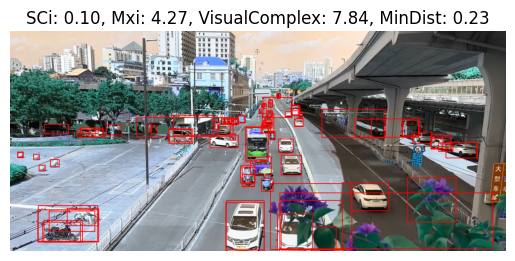

In [ ]:
import torch
from torchvision import models, transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1. 加载预训练的Mask R-CNN模型
model = models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()  # 设置为评估模式

# 2. 加载图像并进行预处理
def preprocess_image(image_path):
    image = cv2.imread(image_path)  # 读取图像
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # 转换为RGB格式
    transform = transforms.Compose([transforms.ToTensor()])  # 归一化
    image_tensor = transform(image_rgb)  # 转换为tensor
    image_tensor = image_tensor.unsqueeze(0)  # 添加批处理维度
    return image, image_tensor

# 3. 执行目标检测和实例分割
def detect_objects(image_path):
    image, image_tensor = preprocess_image(image_path)
    with torch.no_grad():  # 禁用梯度计算，减少内存消耗
        prediction = model(image_tensor)  # 执行预测
    return image, prediction

# 4. 可视化目标检测和实例分割的结果
def visualize_detection(image, prediction, sc, mxi, visualcomplex, mindist):
    # 在图像上绘制目标的边界框
    for box in prediction[0]['boxes']:
        x1, y1, x2, y2 = box.cpu().numpy()
        cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)

    # 使用matplotlib显示图像
    plt.imshow(image)
    plt.title(f"SCi: {sc:.2f}, Mxi: {mxi:.2f}, VisualComplex: {visualcomplex:.2f}, MinDist: {mindist:.2f}")
    plt.axis('off')  # 隐藏坐标轴
    plt.show()

# 假设你已经计算了 SCi、Mxi、VisualComplex 和 MinDist 的值
sc = 0.1  # 示例值
mxi = 4.27  # 示例值
visualcomplex = 7.84  # 示例值
mindist = 0.23  # 示例值

# 示例图像路径
image_path = "Road4.png"  # 替换为你的图像路径

# 检测目标并可视化结果
image, prediction = detect_objects(image_path)
visualize_detection(image, prediction, sc, mxi, visualcomplex, mindist)

In [ ]:
import torch
from torchvision import models, transforms
import cv2
import numpy as np

#######################
# 1. 加载预训练的 Mask R-CNN 模型
#######################
model = models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

#######################
# 2. 预处理
#######################
def preprocess_image(image):
    """
    将输入的图像预处理为模型需要的格式。
    """
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    transform_fn = transforms.Compose([transforms.ToTensor()])
    image_tensor = transform_fn(image_rgb).unsqueeze(0)  # (1, C, H, W)
    return image_tensor

#######################
# 3. 目标检测
#######################
@torch.no_grad()
def detect_objects(image):
    """
    使用 Mask R-CNN 检测目标并返回预测结果。
    """
    image_tensor = preprocess_image(image)
    prediction = model(image_tensor)
    return prediction

#######################
# 4. 指标计算函数
#######################
def calculate_min_distance(boxes):
    """
    计算所有目标之间的最小距离。
    boxes: [N, 4] => [x1, y1, x2, y2]
    """
    if len(boxes) < 2:
        return float('inf')

    centers = [((b[0] + b[2]) / 2, (b[1] + b[3]) / 2) for b in boxes]
    min_dist = float('inf')
    for i in range(len(centers)):
        for j in range(i + 1, len(centers)):
            dist = np.linalg.norm(np.array(centers[i]) - np.array(centers[j]))
            min_dist = min(min_dist, dist)
    return min_dist

def calculate_space_congestion(image, boxes, grid_size=(50, 50)):
    """
    计算空间拥堵度 (SCi)。
    """
    height, width, _ = image.shape
    num_grids_x = width // grid_size[0]
    num_grids_y = height // grid_size[1]
    if num_grids_x == 0 or num_grids_y == 0:
        return 0

    grid_counts = np.zeros((num_grids_y, num_grids_x))
    for box in boxes:
        x1, y1, x2, y2 = box
        gx1, gy1 = int(x1 // grid_size[0]), int(y1 // grid_size[1])
        gx2, gy2 = int(x2 // grid_size[0]), int(y2 // grid_size[1])

        gx1 = max(0, gx1)
        gy1 = max(0, gy1)
        gx2 = min(num_grids_x - 1, gx2)
        gy2 = min(num_grids_y - 1, gy2)

        grid_counts[gy1:gy2+1, gx1:gx2+1] += 1

    total_density = grid_counts.sum() / (num_grids_x * num_grids_y)
    max_count = np.max(grid_counts)
    if max_count == 0:
        return 0

    congestion_score = total_density / max_count
    return congestion_score

def calculate_mxi(boxes):
    """
    混行严重度(Mxi) = 1 / min_dist
    """
    min_dist = calculate_min_distance(boxes)
    if min_dist > 0 and min_dist != float('inf'):
        return 1 / min_dist
    else:
        return 0

#######################
# 5. 主函数：单张图片分析
#######################
def analyze_single_image(image_path):
    """
    给定单张图片，计算并输出 SCi 和 Mxi。
    """
    # 读取图片
    image = cv2.imread(image_path)
    if image is None:
        print(f"无法读取图片：{image_path}")
        return None, None

    # 目标检测
    prediction = detect_objects(image)
    boxes = prediction[0]['boxes'].cpu().numpy() if len(prediction[0]['boxes']) else []

    # 计算指标
    sc = calculate_space_congestion(image, boxes)
    mxi = calculate_mxi(boxes)

    # 打印结果
    print(f"图片：{image_path}")
    print(f"  空间拥堵度（SCi）：{sc:.3f}")
    print(f"  混行严重度（Mxi）：{mxi:.3f}")

    return sc, mxi

#######################
# 6. 使用示例
#######################
if __name__ == "__main__":
    # 替换为实际图片路径
    image_path = "Photo2.jpg"

    # 运行分析
    sc, mxi = analyze_single_image(image_path)

    print("\n分析完成。")
    print(f"SCi: {sc}, Mxi: {mxi}")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:05<00:00, 34.5MB/s]


图片：Photo2.jpg
  空间拥堵度（SCi）：0.421
  混行严重度（Mxi）：0.542

分析完成。
SCi: 0.42111111111111116, Mxi: 0.5422177267285391


In [ ]:
import torch
from torchvision import models, transforms
import cv2
import numpy as np

#######################
# 1. 加载预训练的 Mask R-CNN 模型
#######################
model = models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

#######################
# 2. 预处理
#######################
def preprocess_image(image):
    """
    将输入的图像预处理为模型需要的格式。
    """
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    transform_fn = transforms.Compose([transforms.ToTensor()])
    image_tensor = transform_fn(image_rgb).unsqueeze(0)  # (1, C, H, W)
    return image_tensor

#######################
# 3. 目标检测
#######################
@torch.no_grad()
def detect_objects(image):
    """
    使用 Mask R-CNN 检测目标并返回预测结果。
    """
    image_tensor = preprocess_image(image)
    prediction = model(image_tensor)
    return prediction

#######################
# 4. 指标计算函数
#######################
def calculate_min_distance(boxes):
    """
    计算所有目标之间的最小距离。
    boxes: [N, 4] => [x1, y1, x2, y2]
    """
    if len(boxes) < 2:
        return float('inf')

    centers = [((b[0] + b[2]) / 2, (b[1] + b[3]) / 2) for b in boxes]
    min_dist = float('inf')
    for i in range(len(centers)):
        for j in range(i + 1, len(centers)):
            dist = np.linalg.norm(np.array(centers[i]) - np.array(centers[j]))
            min_dist = min(min_dist, dist)
    return min_dist

def calculate_space_congestion(image, boxes, grid_size=(50, 50)):
    """
    计算空间拥堵度 (SCi)。
    """
    height, width, _ = image.shape
    num_grids_x = width // grid_size[0]
    num_grids_y = height // grid_size[1]
    if num_grids_x == 0 or num_grids_y == 0:
        return 0

    grid_counts = np.zeros((num_grids_y, num_grids_x))
    for box in boxes:
        x1, y1, x2, y2 = box
        gx1, gy1 = int(x1 // grid_size[0]), int(y1 // grid_size[1])
        gx2, gy2 = int(x2 // grid_size[0]), int(y2 // grid_size[1])

        gx1 = max(0, gx1)
        gy1 = max(0, gy1)
        gx2 = min(num_grids_x - 1, gx2)
        gy2 = min(num_grids_y - 1, gy2)

        grid_counts[gy1:gy2+1, gx1:gx2+1] += 1

    total_density = grid_counts.sum() / (num_grids_x * num_grids_y)
    max_count = np.max(grid_counts)
    if max_count == 0:
        return 0

    congestion_score = total_density / max_count
    return congestion_score

def calculate_mxi(boxes):
    """
    混行严重度(Mxi) = 1 / min_dist
    """
    min_dist = calculate_min_distance(boxes)
    if min_dist > 0 and min_dist != float('inf'):
        return 1 / min_dist
    else:
        return 0

#######################
# 5. 主函数：单张图片分析
#######################
def analyze_single_image(image_path):
    """
    给定单张图片，计算并输出 SCi 和 Mxi。
    """
    # 读取图片
    image = cv2.imread(image_path)
    if image is None:
        print(f"无法读取图片：{image_path}")
        return None, None

    # 目标检测
    prediction = detect_objects(image)
    boxes = prediction[0]['boxes'].cpu().numpy() if len(prediction[0]['boxes']) else []

    # 计算指标
    sc = calculate_space_congestion(image, boxes)
    mxi = calculate_mxi(boxes)

    # 打印结果
    print(f"图片：{image_path}")
    print(f"  空间拥堵度（SCi）：{sc:.3f}")
    print(f"  混行严重度（Mxi）：{mxi:.3f}")

    return sc, mxi

#######################
# 6. 使用示例
#######################
if __name__ == "__main__":
    # 替换为实际图片路径
    image_path = "Road2.png"

    # 运行分析
    sc, mxi = analyze_single_image(image_path)

    print("\n分析完成。")
    print(f"SCi: {sc}, Mxi: {mxi}")

图片：Road2.png
  空间拥堵度（SCi）：0.069
  混行严重度（Mxi）：12.909

分析完成。
SCi: 0.06898219814241487, Mxi: 12.908584006978852


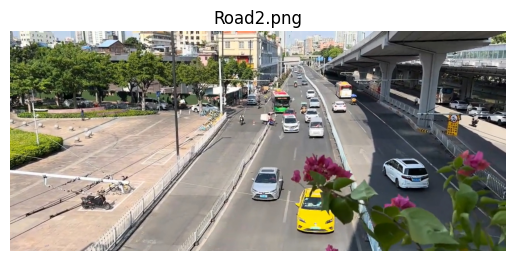

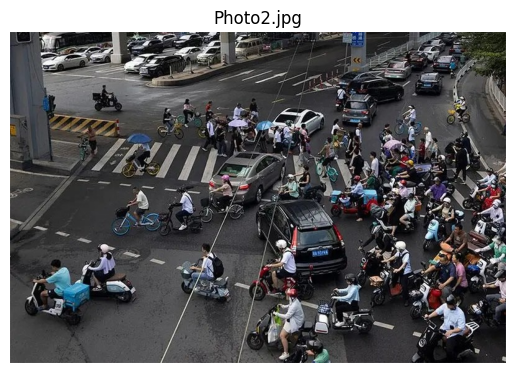

In [ ]:
import cv2
import matplotlib.pyplot as plt

# 定义显示图片的函数
def display_image(image_path):
    image = cv2.imread(image_path)  # 读取图片
    if image is None:
        print(f"无法读取图片：{image_path}")
        return
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # 转换为 RGB 格式
    plt.imshow(image_rgb)
    plt.title(image_path)
    plt.axis('off')  # 隐藏坐标轴
    plt.show()

# 显示 Road2.png
display_image("Road2.png")

# 显示 Photo2.jpg
display_image("Photo2.jpg")


In [ ]:
import torch
from torchvision import models, transforms
import cv2
import numpy as np

#######################
# 1. 加载预训练的 Mask R-CNN 模型
#######################
model = models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

#######################
# 2. 预处理
#######################
def preprocess_image(image):
    """
    将输入的图像预处理为模型需要的格式。
    """
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    transform_fn = transforms.Compose([transforms.ToTensor()])
    image_tensor = transform_fn(image_rgb).unsqueeze(0)  # (1, C, H, W)
    return image_tensor

#######################
# 3. 目标检测
#######################
@torch.no_grad()
def detect_objects(image):
    """
    使用 Mask R-CNN 检测目标并返回预测结果。
    """
    image_tensor = preprocess_image(image)
    prediction = model(image_tensor)
    return prediction

#######################
# 4. 指标计算函数
#######################
def calculate_min_distance(boxes):
    """
    计算所有目标之间的最小距离。
    boxes: [N, 4] => [x1, y1, x2, y2]
    """
    if len(boxes) < 2:
        return float('inf')

    centers = [((b[0] + b[2]) / 2, (b[1] + b[3]) / 2) for b in boxes]
    min_dist = float('inf')
    for i in range(len(centers)):
        for j in range(i + 1, len(centers)):
            dist = np.linalg.norm(np.array(centers[i]) - np.array(centers[j]))
            min_dist = min(min_dist, dist)
    return min_dist

def calculate_space_congestion(image, boxes, grid_size=(50, 50)):
    """
    计算空间拥堵度 (SCi)。
    """
    height, width, _ = image.shape
    num_grids_x = width // grid_size[0]
    num_grids_y = height // grid_size[1]
    if num_grids_x == 0 or num_grids_y == 0:
        return 0

    grid_counts = np.zeros((num_grids_y, num_grids_x))
    for box in boxes:
        x1, y1, x2, y2 = box
        gx1, gy1 = int(x1 // grid_size[0]), int(y1 // grid_size[1])
        gx2, gy2 = int(x2 // grid_size[0]), int(y2 // grid_size[1])

        gx1 = max(0, gx1)
        gy1 = max(0, gy1)
        gx2 = min(num_grids_x - 1, gx2)
        gy2 = min(num_grids_y - 1, gy2)

        grid_counts[gy1:gy2+1, gx1:gx2+1] += 1

    total_density = grid_counts.sum() / (num_grids_x * num_grids_y)
    max_count = np.max(grid_counts)
    if max_count == 0:
        return 0

    congestion_score = total_density / max_count
    return congestion_score

def calculate_mxi_with_density(image, boxes):
    """
    改进混行严重度计算，结合目标密度和加权平均距离。
    """
    if len(boxes) < 2:
        return 0  # 无法计算混行严重度

    # 1. 计算目标密度
    height, width, _ = image.shape
    area = height * width
    density = len(boxes) / area  # 每像素目标数

    # 2. 计算所有目标中心点
    centers = [((b[0] + b[2]) / 2, (b[1] + b[3]) / 2) for b in boxes]

    # 3. 计算所有目标之间的距离，并加权
    distances = []
    weights = []
    for i in range(len(centers)):
        for j in range(i + 1, len(centers)):
            dist = np.linalg.norm(np.array(centers[i]) - np.array(centers[j]))
            distances.append(dist)
            weights.append(1 / (dist + 1e-5))  # 距离越短，权重越高

    # 4. 加权平均距离
    if len(distances) > 0:
        weighted_avg_distance = np.sum(np.array(distances) * np.array(weights)) / np.sum(weights)
    else:
        weighted_avg_distance = float('inf')

    # 5. 计算最终 Mxi
    mxi = density / weighted_avg_distance if weighted_avg_distance > 0 else 0
    return mxi

#######################
# 5. 主函数：单张图片分析
#######################
def analyze_single_image(image_path):
    """
    给定单张图片，计算并输出 SCi 和 Mxi。
    """
    # 读取图片
    image = cv2.imread(image_path)
    if image is None:
        print(f"无法读取图片：{image_path}")
        return None, None

    # 目标检测
    prediction = detect_objects(image)
    boxes = prediction[0]['boxes'].cpu().numpy() if len(prediction[0]['boxes']) else []

    # 计算指标
    sc = calculate_space_congestion(image, boxes)
    mxi = calculate_mxi(boxes)

    # 打印结果
    print(f"图片：{image_path}")
    print(f"  空间拥堵度（SCi）：{sc:.3f}")
    print(f"  混行严重度（Mxi）：{mxi:.3f}")

    return sc, mxi

#######################
# 6. 使用示例
#######################
if __name__ == "__main__":
    # 替换为实际图片路径
    image_path = "Road2.png"

    # 运行分析
    sc, mxi = analyze_single_image(image_path)

    print("\n分析完成。")
    print(f"SCi: {sc}, Mxi: {mxi}")

图片：Road2.png
  空间拥堵度（SCi）：0.069
  混行严重度（Mxi）：12.909

分析完成。
SCi: 0.06898219814241487, Mxi: 12.908584006978852


In [ ]:
import torch
from torchvision import models, transforms
import cv2
import numpy as np

#######################
# 1. 加载预训练的 Mask R-CNN 模型
#######################
model = models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

#######################
# 2. 预处理
#######################
def preprocess_image(image):
    """
    将输入的图像预处理为模型需要的格式。
    """
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    transform_fn = transforms.Compose([transforms.ToTensor()])
    image_tensor = transform_fn(image_rgb).unsqueeze(0)  # (1, C, H, W)
    return image_tensor

#######################
# 3. 目标检测
#######################
@torch.no_grad()
def detect_objects(image):
    """
    使用 Mask R-CNN 检测目标并返回预测结果。
    """
    image_tensor = preprocess_image(image)
    prediction = model(image_tensor)
    return prediction

#######################
# 4. 指标计算函数
#######################
def calculate_min_distance(boxes):
    """
    计算所有目标之间的最小距离。
    boxes: [N, 4] => [x1, y1, x2, y2]
    """
    if len(boxes) < 2:
        return float('inf')

    centers = [((b[0] + b[2]) / 2, (b[1] + b[3]) / 2) for b in boxes]
    min_dist = float('inf')
    for i in range(len(centers)):
        for j in range(i + 1, len(centers)):
            dist = np.linalg.norm(np.array(centers[i]) - np.array(centers[j]))
            min_dist = min(min_dist, dist)
    return min_dist

def calculate_space_congestion(image, boxes, grid_size=(50, 50)):
    """
    计算空间拥堵度 (SCi)。
    """
    height, width, _ = image.shape
    num_grids_x = width // grid_size[0]
    num_grids_y = height // grid_size[1]
    if num_grids_x == 0 or num_grids_y == 0:
        return 0

    grid_counts = np.zeros((num_grids_y, num_grids_x))
    for box in boxes:
        x1, y1, x2, y2 = box
        gx1, gy1 = int(x1 // grid_size[0]), int(y1 // grid_size[1])
        gx2, gy2 = int(x2 // grid_size[0]), int(y2 // grid_size[1])

        gx1 = max(0, gx1)
        gy1 = max(0, gy1)
        gx2 = min(num_grids_x - 1, gx2)
        gy2 = min(num_grids_y - 1, gy2)

        grid_counts[gy1:gy2+1, gx1:gx2+1] += 1

    total_density = grid_counts.sum() / (num_grids_x * num_grids_y)
    max_count = np.max(grid_counts)
    if max_count == 0:
        return 0

    congestion_score = total_density / max_count
    return congestion_score

def calculate_mxi_with_density(image, boxes):
    """
    改进混行严重度计算，结合目标密度和加权平均距离。
    """
    if len(boxes) < 2:
        return 0  # 无法计算混行严重度

    # 1. 计算目标密度
    height, width, _ = image.shape
    area = height * width
    density = len(boxes) / area  # 每像素目标数

    # 2. 计算所有目标中心点
    centers = [((b[0] + b[2]) / 2, (b[1] + b[3]) / 2) for b in boxes]

    # 3. 计算所有目标之间的距离，并加权
    distances = []
    weights = []
    for i in range(len(centers)):
        for j in range(i + 1, len(centers)):
            dist = np.linalg.norm(np.array(centers[i]) - np.array(centers[j]))
            distances.append(dist)
            weights.append(1 / (dist + 1e-5))  # 距离越短，权重越高

    # 4. 加权平均距离
    if len(distances) > 0:
        weighted_avg_distance = np.sum(np.array(distances) * np.array(weights)) / np.sum(weights)
    else:
        weighted_avg_distance = float('inf')

    # 5. 计算最终 Mxi
    mxi = density / weighted_avg_distance if weighted_avg_distance > 0 else 0
    return mxi

#######################
# 5. 主函数：单张图片分析
#######################
def analyze_single_image(image_path):
    """
    给定单张图片，计算并输出 SCi 和 Mxi。
    """
    # 读取图片
    image = cv2.imread(image_path)
    if image is None:
        print(f"无法读取图片：{image_path}")
        return None, None

    # 目标检测
    prediction = detect_objects(image)
    boxes = prediction[0]['boxes'].cpu().numpy() if len(prediction[0]['boxes']) else []

    # 计算指标
    sc = calculate_space_congestion(image, boxes)
    mxi = calculate_mxi(boxes)

    # 打印结果
    print(f"图片：{image_path}")
    print(f"  空间拥堵度（SCi）：{sc:.3f}")
    print(f"  混行严重度（Mxi）：{mxi:.3f}")

    return sc, mxi

#######################
# 6. 使用示例
#######################
if __name__ == "__main__":
    # 替换为实际图片路径
    image_path = "Photo2.jpg"

    # 运行分析
    sc, mxi = analyze_single_image(image_path)

    print("\n分析完成。")
    print(f"SCi: {sc}, Mxi: {mxi}")

图片：Photo2.jpg
  空间拥堵度（SCi）：0.421
  混行严重度（Mxi）：0.542

分析完成。
SCi: 0.42111111111111116, Mxi: 0.5422177267285391


图片：Road2.png
  空间拥堵度（SCi）：0.069
  混行严重度（Mxi）：0.000


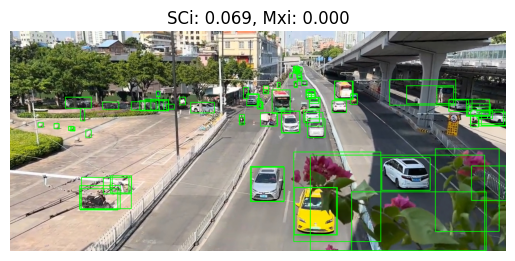

图片：Photo2.jpg
  空间拥堵度（SCi）：0.421
  混行严重度（Mxi）：0.000


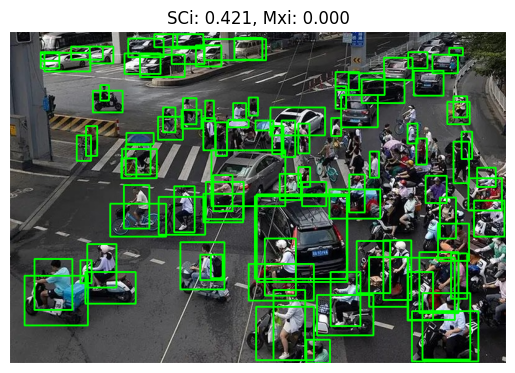

In [ ]:
import torch
from torchvision import models, transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt

#######################
# 1. 加载预训练的 Mask R-CNN 模型
#######################
model = models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

#######################
# 2. 预处理
#######################
def preprocess_image(image):
    """
    将输入的图像预处理为模型需要的格式。
    """
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    transform_fn = transforms.Compose([transforms.ToTensor()])
    image_tensor = transform_fn(image_rgb).unsqueeze(0)  # (1, C, H, W)
    return image_tensor

#######################
# 3. 目标检测
#######################
@torch.no_grad()
def detect_objects(image):
    """
    使用 Mask R-CNN 检测目标并返回预测结果。
    """
    image_tensor = preprocess_image(image)
    prediction = model(image_tensor)
    return prediction

#######################
# 4. 指标计算函数
#######################
def calculate_space_congestion(image, boxes, grid_size=(50, 50)):
    """
    计算空间拥堵度 (SCi)。
    """
    height, width, _ = image.shape
    num_grids_x = width // grid_size[0]
    num_grids_y = height // grid_size[1]
    if num_grids_x == 0 or num_grids_y == 0:
        return 0

    grid_counts = np.zeros((num_grids_y, num_grids_x))
    for box in boxes:
        x1, y1, x2, y2 = box
        gx1, gy1 = int(x1 // grid_size[0]), int(y1 // grid_size[1])
        gx2, gy2 = int(x2 // grid_size[0]), int(y2 // grid_size[1])

        gx1 = max(0, gx1)
        gy1 = max(0, gy1)
        gx2 = min(num_grids_x - 1, gx2)
        gy2 = min(num_grids_y - 1, gy2)

        grid_counts[gy1:gy2+1, gx1:gx2+1] += 1

    total_density = grid_counts.sum() / (num_grids_x * num_grids_y)
    max_count = np.max(grid_counts)
    if max_count == 0:
        return 0

    congestion_score = total_density / max_count
    return congestion_score

def calculate_mxi_with_density(image, boxes):
    """
    改进混行严重度 (Mxi) 计算，结合目标密度和加权平均距离。
    """
    if len(boxes) < 2:
        return 0  # 无法计算混行严重度

    # 1. 计算目标密度
    height, width, _ = image.shape
    area = height * width
    density = len(boxes) / area  # 每像素目标数

    # 2. 计算所有目标中心点
    centers = [((b[0] + b[2]) / 2, (b[1] + b[3]) / 2) for b in boxes]

    # 3. 计算所有目标之间的距离，并加权
    distances = []
    weights = []
    for i in range(len(centers)):
        for j in range(i + 1, len(centers)):
            dist = np.linalg.norm(np.array(centers[i]) - np.array(centers[j]))
            distances.append(dist)
            weights.append(1 / (dist + 1e-5))  # 距离越短，权重越高

    # 4. 加权平均距离
    if len(distances) > 0:
        weighted_avg_distance = np.sum(np.array(distances) * np.array(weights)) / np.sum(weights)
    else:
        weighted_avg_distance = float('inf')

    # 5. 计算最终 Mxi
    mxi = density / weighted_avg_distance if weighted_avg_distance > 0 else 0
    return mxi

#######################
# 5. 可视化
#######################
def visualize_results(image, boxes, sc, mxi):
    """
    可视化目标检测结果和计算指标。
    """
    for box in boxes:
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.title(f"SCi: {sc:.3f}, Mxi: {mxi:.3f}")
    plt.axis('off')
    plt.show()

#######################
# 6. 主函数：单张图片分析
#######################
def analyze_single_image(image_path):
    """
    给定单张图片，计算并输出 SCi 和 Mxi。
    """
    # 读取图片
    image = cv2.imread(image_path)
    if image is None:
        print(f"无法读取图片：{image_path}")
        return None, None

    # 目标检测
    prediction = detect_objects(image)
    boxes = prediction[0]['boxes'].cpu().numpy() if len(prediction[0]['boxes']) else []

    # 计算指标
    sc = calculate_space_congestion(image, boxes)
    mxi = calculate_mxi_with_density(image, boxes)

    # 打印结果
    print(f"图片：{image_path}")
    print(f"  空间拥堵度（SCi）：{sc:.3f}")
    print(f"  混行严重度（Mxi）：{mxi:.3f}")

    # 可视化结果
    visualize_results(image, boxes, sc, mxi)

    return sc, mxi

#######################
# 7. 使用示例
#######################
if __name__ == "__main__":
    # 分别分析两张图片
    analyze_single_image("Road2.png")
    analyze_single_image("Photo2.jpg")


图片：Road2.png
  空间拥堵度（SCi）：0.069
  混行严重度（Mxi）：2.893


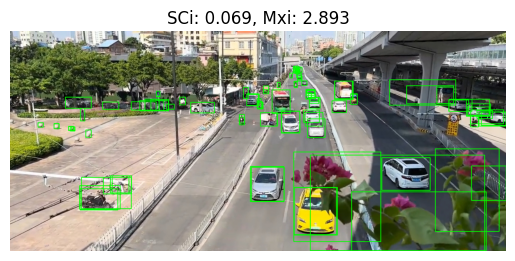

图片：Photo2.jpg
  空间拥堵度（SCi）：0.421
  混行严重度（Mxi）：2.777


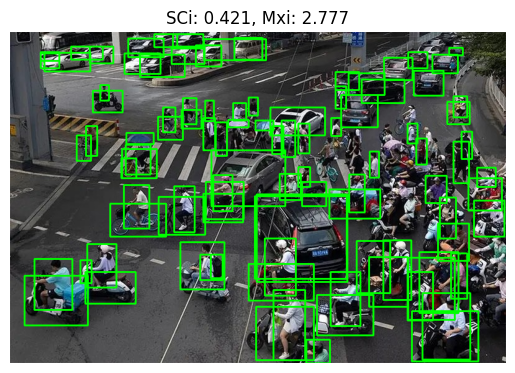

In [ ]:
import torch
from torchvision import models, transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt

#######################
# 1. 加载预训练的 Mask R-CNN 模型
#######################
model = models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

#######################
# 2. 预处理
#######################
def preprocess_image(image):
    """
    将输入的图像预处理为模型需要的格式。
    """
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    transform_fn = transforms.Compose([transforms.ToTensor()])
    image_tensor = transform_fn(image_rgb).unsqueeze(0)  # (1, C, H, W)
    return image_tensor

#######################
# 3. 目标检测
#######################
@torch.no_grad()
def detect_objects(image):
    """
    使用 Mask R-CNN 检测目标并返回预测结果。
    """
    image_tensor = preprocess_image(image)
    prediction = model(image_tensor)
    return prediction

#######################
# 4. 指标计算函数
#######################
def calculate_space_congestion(image, boxes, grid_size=(50, 50)):
    """
    计算空间拥堵度 (SCi)。
    """
    height, width, _ = image.shape
    num_grids_x = width // grid_size[0]
    num_grids_y = height // grid_size[1]
    if num_grids_x == 0 or num_grids_y == 0:
        return 0

    grid_counts = np.zeros((num_grids_y, num_grids_x))
    for box in boxes:
        x1, y1, x2, y2 = box
        gx1, gy1 = int(x1 // grid_size[0]), int(y1 // grid_size[1])
        gx2, gy2 = int(x2 // grid_size[0]), int(y2 // grid_size[1])

        gx1 = max(0, gx1)
        gy1 = max(0, gy1)
        gx2 = min(num_grids_x - 1, gx2)
        gy2 = min(num_grids_y - 1, gy2)

        grid_counts[gy1:gy2+1, gx1:gx2+1] += 1

    total_density = grid_counts.sum() / (num_grids_x * num_grids_y)
    max_count = np.max(grid_counts)
    if max_count == 0:
        return 0

    congestion_score = total_density / max_count
    return congestion_score

def calculate_mxi_with_overlap_v3(image, boxes):
    """
    改进混行严重度 (Mxi) 计算，调整权重：
    - 增大重叠比率的权重 β 为 3.0。
    - 减小平均距离的权重 α 为 0.3。
    """
    if len(boxes) < 2:
        return 0  # 无法计算混行严重度

    # 1. 计算目标密度
    height, width, _ = image.shape
    area = height * width
    density = len(boxes) / area  # 每像素目标数

    # 2. 计算所有目标中心点
    centers = [((b[0] + b[2]) / 2, (b[1] + b[3]) / 2) for b in boxes]

    # 3. 计算所有目标之间的平均距离
    distances = []
    for i in range(len(centers)):
        for j in range(i + 1, len(centers)):
            dist = np.linalg.norm(np.array(centers[i]) - np.array(centers[j]))
            distances.append(dist)

    avg_distance = np.mean(distances) if distances else float('inf')

    # 4. 计算目标框之间的最大重叠比率
    def calculate_overlap(box1, box2):
        x1 = max(box1[0], box2[0])
        y1 = max(box1[1], box2[1])
        x2 = min(box1[2], box2[2])
        y2 = min(box1[3], box2[3])
        overlap_area = max(0, x2 - x1) * max(0, y2 - y1)
        box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
        box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
        total_area = box1_area + box2_area - overlap_area
        return overlap_area / total_area if total_area > 0 else 0

    overlap_ratios = []
    for i in range(len(boxes)):
        for j in range(i + 1, len(boxes)):
            overlap_ratios.append(calculate_overlap(boxes[i], boxes[j]))

    max_overlap = max(overlap_ratios) if overlap_ratios else 0

    # 5. 综合计算 Mxi
    alpha = 0.3
    beta = 3.0
    epsilon = 1e-5
    mxi = alpha * (density / (avg_distance + epsilon)) + beta * max_overlap
    return mxi

#######################
# 5. 可视化
#######################
def visualize_results(image, boxes, sc, mxi):
    """
    可视化目标检测结果和计算指标。
    """
    for box in boxes:
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.title(f"SCi: {sc:.3f}, Mxi: {mxi:.3f}")
    plt.axis('off')
    plt.show()

#######################
# 6. 主函数：单张图片分析
#######################
def analyze_single_image(image_path):
    """
    给定单张图片，计算并输出 SCi 和 Mxi。
    """
    # 读取图片
    image = cv2.imread(image_path)
    if image is None:
        print(f"无法读取图片：{image_path}")
        return None, None

    # 目标检测
    prediction = detect_objects(image)
    boxes = prediction[0]['boxes'].cpu().numpy() if len(prediction[0]['boxes']) else []

    # 计算指标
    sc = calculate_space_congestion(image, boxes)
    mxi = calculate_mxi_with_overlap_v3(image, boxes)

    # 打印结果
    print(f"图片：{image_path}")
    print(f"  空间拥堵度（SCi）：{sc:.3f}")
    print(f"  混行严重度（Mxi）：{mxi:.3f}")

    # 可视化结果
    visualize_results(image, boxes, sc, mxi)

    return sc, mxi

#######################
# 7. 使用示例
#######################
if __name__ == "__main__":
    # 分别分析两张图片
    analyze_single_image("Road2.png")
    analyze_single_image("Photo2.jpg")


图片：Road2.png
  新混行严重度（New Mxi）：0.005


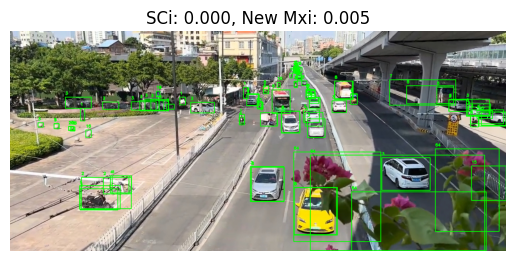

图片：Photo2.jpg
  新混行严重度（New Mxi）：0.008


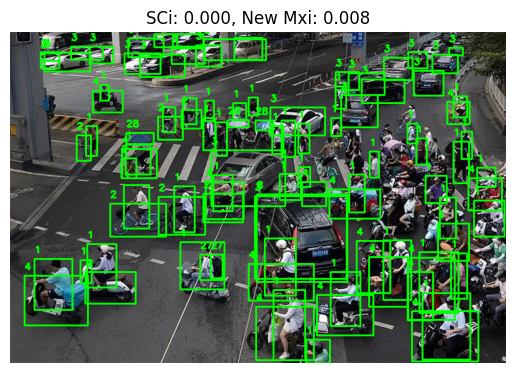

In [ ]:
import torch
from torchvision import models, transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt

#######################
# 1. 加载预训练的 Mask R-CNN 模型
#######################
model = models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

#######################
# 2. 预处理
#######################
def preprocess_image(image):
    """
    将输入的图像预处理为模型需要的格式。
    """
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    transform_fn = transforms.Compose([transforms.ToTensor()])
    image_tensor = transform_fn(image_rgb).unsqueeze(0)  # (1, C, H, W)
    return image_tensor

#######################
# 3. 目标检测
#######################
@torch.no_grad()
def detect_objects(image):
    """
    使用 Mask R-CNN 检测目标并返回预测结果。
    """
    image_tensor = preprocess_image(image)
    prediction = model(image_tensor)
    return prediction

#######################
# 4. 新混行严重度计算
#######################
def calculate_new_mxi(image, prediction):
    """
    计算基于不同交通主体类型的新的混行严重度。
    """
    # 提取目标框、类型和置信度
    boxes = prediction[0]['boxes'].cpu().numpy()
    labels = prediction[0]['labels'].cpu().numpy()  # 类别标签
    scores = prediction[0]['scores'].cpu().numpy()

    # 筛选高置信度目标
    threshold = 0.5
    valid_indices = scores >= threshold
    boxes = boxes[valid_indices]
    labels = labels[valid_indices]

    # 类型间权重矩阵（可以根据实际情况调整）
    type_weights = {
        (1, 2): 2.0,  # 行人与汽车
        (1, 3): 1.5,  # 行人与自行车
        (1, 4): 2.5,  # 行人与摩托车
        (2, 3): 1.5,  # 汽车与自行车
        (2, 4): 2.0,  # 汽车与摩托车
        (3, 4): 1.8,  # 自行车与摩托车
        (1, 1): 1.0,  # 行人之间
        (2, 2): 1.0,  # 汽车之间
        (3, 3): 1.0,  # 自行车之间
        (4, 4): 1.2   # 摩托车之间
    }

    # 计算类型间的交互影响
    interaction_sum = 0
    total_pairs = 0

    for i in range(len(boxes)):
        for j in range(i + 1, len(boxes)):
            type_i = labels[i]
            type_j = labels[j]
            dist = np.linalg.norm(np.array([(boxes[i][0] + boxes[i][2]) / 2, (boxes[i][1] + boxes[i][3]) / 2]) -
                                  np.array([(boxes[j][0] + boxes[j][2]) / 2, (boxes[j][1] + boxes[j][3]) / 2]))
            weight = type_weights.get((min(type_i, type_j), max(type_i, type_j)), 1.0)
            interaction_sum += weight / (dist + 1e-5)
            total_pairs += 1

    # 计算新的混行程度
    mxi_new = interaction_sum / total_pairs if total_pairs > 0 else 0
    return mxi_new

#######################
# 5. 可视化
#######################
def visualize_results(image, boxes, labels, sc, mxi_new):
    """
    可视化目标检测结果和计算指标。
    """
    for box, label in zip(boxes, labels):
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(image, str(label), (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.title(f"SCi: {sc:.3f}, New Mxi: {mxi_new:.3f}")
    plt.axis('off')
    plt.show()

#######################
# 6. 主函数：单张图片分析
#######################
def analyze_single_image(image_path):
    """
    给定单张图片，计算并输出 SCi 和新的混行严重度 (New Mxi)。
    """
    # 读取图片
    image = cv2.imread(image_path)
    if image is None:
        print(f"无法读取图片：{image_path}")
        return None, None

    # 目标检测
    prediction = detect_objects(image)

    # 计算新混行严重度
    mxi_new = calculate_new_mxi(image, prediction)

    # 提取有效目标框和类型用于可视化
    boxes = prediction[0]['boxes'].cpu().numpy()
    labels = prediction[0]['labels'].cpu().numpy()

    # 打印结果
    print(f"图片：{image_path}")
    print(f"  新混行严重度（New Mxi）：{mxi_new:.3f}")

    # 可视化结果
    visualize_results(image, boxes, labels, 0, mxi_new)  # 这里 SCi 设置为 0 仅作占位

    return mxi_new

#######################
# 7. 使用示例
#######################
if __name__ == "__main__":
    # 分别分析两张图片
    analyze_single_image("Road2.png")
    analyze_single_image("Photo2.jpg")


2025-01-27

In [ ]:
import torch
from torchvision import models, transforms
import cv2
import numpy as np
import pandas as pd

#######################
# 1. 加载预训练的 Mask R-CNN 模型
#######################
model = models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")
model.eval()

#######################
# 2. 预处理
#######################
def preprocess_image(image):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    transform_fn = transforms.Compose([transforms.ToTensor()])
    image_tensor = transform_fn(image_rgb).unsqueeze(0)  # (1, C, H, W)
    return image_tensor

#######################
# 3. 目标检测
#######################
@torch.no_grad()
def detect_objects(image):
    image_tensor = preprocess_image(image)
    prediction = model(image_tensor)
    return prediction

#######################
# 4. 新混行严重度计算
#######################
def calculate_new_mxi(image, prediction):
    """
    计算基于不同交通主体类型的新的混行严重度。
    """
    # 提取目标框、类型和置信度
    boxes = prediction[0]['boxes'].cpu().numpy()
    labels = prediction[0]['labels'].cpu().numpy()  # 类别标签
    scores = prediction[0]['scores'].cpu().numpy()

    # 筛选高置信度目标
    threshold = 0.5
    valid_indices = scores >= threshold
    boxes = boxes[valid_indices]
    labels = labels[valid_indices]

    # 类型间权重矩阵（可以根据实际情况调整）
    type_weights = {
        (1, 2): 2.0,  # 行人与汽车
        (1, 3): 1.5,  # 行人与自行车
        (1, 4): 2.5,  # 行人与摩托车
        (2, 3): 1.5,  # 汽车与自行车
        (2, 4): 2.0,  # 汽车与摩托车
        (3, 4): 1.8,  # 自行车与摩托车
        (1, 1): 1.0,  # 行人之间
        (2, 2): 1.0,  # 汽车之间
        (3, 3): 1.0,  # 自行车之间
        (4, 4): 1.2   # 摩托车之间
    }

    # 计算类型间的交互影响
    interaction_sum = 0
    total_pairs = 0

    for i in range(len(boxes)):
        for j in range(i + 1, len(boxes)):
            type_i = labels[i]
            type_j = labels[j]
            dist = np.linalg.norm(np.array([(boxes[i][0] + boxes[i][2]) / 2, (boxes[i][1] + boxes[i][3]) / 2]) -
                                  np.array([(boxes[j][0] + boxes[j][2]) / 2, (boxes[j][1] + boxes[j][3]) / 2]))
            weight = type_weights.get((min(type_i, type_j), max(type_i, type_j)), 1.0)
            interaction_sum += weight / (dist + 1e-5)
            total_pairs += 1

    # 计算新的混行程度
    mxi_new = interaction_sum / total_pairs if total_pairs > 0 else 0
    return mxi_new

#######################
# 5. 最小距离计算
#######################
def calculate_min_distance(boxes):
    """
    计算所有目标之间的最小距离。
    """
    if len(boxes) < 2:
        return float('inf')

    centers = [((b[0] + b[2]) / 2, (b[1] + b[3]) / 2) for b in boxes]
    min_dist = float('inf')
    for i in range(len(centers)):
        for j in range(i + 1, len(centers)):
            dist = np.linalg.norm(np.array(centers[i]) - np.array(centers[j]))
            min_dist = min(min_dist, dist)
    return min_dist

#######################
# 6. 综合近距冲突频次计算
#######################
def compute_time_conflict_frequency(mxi_values, min_distances, mxi_threshold, dist_threshold, time_interval=2.0):
    """
    综合基于 Mxi 和最小距离计算近距冲突频次。
    """
    conflict_count = sum(
        1 for mxi, dist in zip(mxi_values, min_distances)
        if mxi > mxi_threshold or dist < dist_threshold
    )

    n_frames = len(mxi_values)
    if n_frames > 1:
        total_seconds = (n_frames - 1) * time_interval
    else:
        total_seconds = time_interval

    conflicts_per_second = conflict_count / total_seconds if total_seconds > 0 else 0
    return conflicts_per_second

#######################
# 7. 主函数: 多张图片模拟时间序列
#######################
def analyze_images_as_time_sequence(image_paths, mxi_threshold=0.005, dist_threshold=50, time_interval=2.0):
    """
    分析多张图片的时间序列，计算 SCi、New Mxi、VisualComplex 和 Near-Conflict Frequency。
    """
    results = []
    mxi_values = []
    min_distances = []

    for idx, img_path in enumerate(image_paths):
        frame = cv2.imread(img_path)
        if frame is None:
            print(f"无法读取图像 {img_path}")
            continue

        # 目标检测
        prediction = detect_objects(frame)

        # 计算指标
        boxes = prediction[0]['boxes'].cpu().numpy() if len(prediction[0]['boxes']) else []
        sc = calculate_space_congestion(frame, boxes)
        mxi = calculate_new_mxi(frame, prediction)
        vc = calculate_visual_complexity(frame)
        min_dist = calculate_min_distance(boxes)

        # 保存 Mxi 和最小距离用于时间序列分析
        mxi_values.append(mxi)
        min_distances.append(min_dist)

        # 输出当前帧结果
        print(f"Frame {idx} ({img_path}):")
        print(f"  SCi={sc:.3f}, New Mxi={mxi:.3f}, VisualComplex={vc:.3f}, MinDist={min_dist:.3f}")

        results.append((idx, img_path, sc, mxi, vc, min_dist))

    # 计算综合近距冲突频次
    near_conflict_freq = compute_time_conflict_frequency(
        mxi_values, min_distances, mxi_threshold, dist_threshold, time_interval
    )
    print(f"\n=== 多张图像近距冲突频次: {near_conflict_freq:.3f} 次/秒 ===")

    # 保存到CSV
    df = pd.DataFrame(results, columns=['Frame', 'ImagePath', 'SCi', 'New Mxi', 'VisualComplex', 'MinDist'])
    df.to_csv('multiple_images_results.csv', index=False)
    print("结果已保存: multiple_images_results.csv")

    return df, near_conflict_freq

#######################
# 8. 使用示例
#######################
if __name__ == "__main__":
    # 假设有三张图片, 间隔2秒
    image_list = [
        "Road2.png",
        "Road3.png",
        "Road4.png"
    ]

    # 运行分析
    df, conflict_per_second = analyze_images_as_time_sequence(
        image_paths=image_list,
        mxi_threshold=0.005,       # 冲突事件的 Mxi 阈值
        dist_threshold=50,        # 冲突事件的最小距离阈值
        time_interval=2.0         # 2 秒间隔
    )

    print("\n分析结束.")
    print(df)
    print(f"近距冲突频次(次/秒): {conflict_per_second:.3f}")

Frame 0 (Road2.png):
  SCi=0.069, New Mxi=0.005, VisualComplex=7.817, MinDist=0.077
Frame 1 (Road3.png):
  SCi=0.071, New Mxi=0.006, VisualComplex=7.787, MinDist=0.371
Frame 2 (Road4.png):
  SCi=0.096, New Mxi=0.005, VisualComplex=7.842, MinDist=0.234

=== 多张图像近距冲突频次: 0.750 次/秒 ===
结果已保存: multiple_images_results.csv

分析结束.
   Frame  ImagePath       SCi   New Mxi  VisualComplex   MinDist
0      0  Road2.png  0.068982  0.005500       7.816743  0.077468
1      1  Road3.png  0.070530  0.005539       7.787105  0.370516
2      2  Road4.png  0.095553  0.004840       7.842158  0.234353
近距冲突频次(次/秒): 0.750


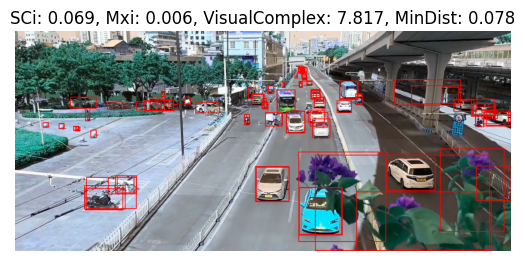

In [ ]:
import torch
from torchvision import models, transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1. 加载预训练的Mask R-CNN模型
model = models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()  # 设置为评估模式

# 2. 加载图像并进行预处理
def preprocess_image(image_path):
    image = cv2.imread(image_path)  # 读取图像
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # 转换为RGB格式
    transform = transforms.Compose([transforms.ToTensor()])  # 归一化
    image_tensor = transform(image_rgb)  # 转换为tensor
    image_tensor = image_tensor.unsqueeze(0)  # 添加批处理维度
    return image, image_tensor

# 3. 执行目标检测和实例分割
def detect_objects(image_path):
    image, image_tensor = preprocess_image(image_path)
    with torch.no_grad():  # 禁用梯度计算，减少内存消耗
        prediction = model(image_tensor)  # 执行预测
    return image, prediction

# 4. 可视化目标检测和实例分割的结果
def visualize_detection(image, prediction, sc, mxi, visualcomplex, mindist):
    # 在图像上绘制目标的边界框
    for box in prediction[0]['boxes']:
        x1, y1, x2, y2 = box.cpu().numpy()
        cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)

    # 使用matplotlib显示图像
    plt.imshow(image)
    plt.title(f"SCi: {sc:.3f}, Mxi: {mxi:.3f}, VisualComplex: {visualcomplex:.3f}, MinDist: {mindist:.3f}")
    plt.axis('off')  # 隐藏坐标轴
    plt.show()

# 假设你已经计算了 SCi、Mxi、VisualComplex 和 MinDist 的值
sc = 0.069  # 示例值
mxi = 0.006  # 示例值
visualcomplex = 7.817  # 示例值
mindist = 0.078  # 示例值

# 示例图像路径
image_path = "Road2.png"  # 替换为你的图像路径

# 检测目标并可视化结果
image, prediction = detect_objects(image_path)
visualize_detection(image, prediction, sc, mxi, visualcomplex, mindist)

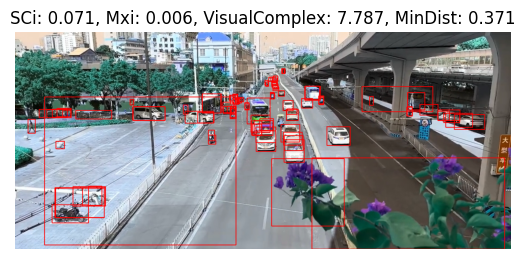

In [ ]:
import torch
from torchvision import models, transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1. 加载预训练的Mask R-CNN模型
model = models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()  # 设置为评估模式

# 2. 加载图像并进行预处理
def preprocess_image(image_path):
    image = cv2.imread(image_path)  # 读取图像
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # 转换为RGB格式
    transform = transforms.Compose([transforms.ToTensor()])  # 归一化
    image_tensor = transform(image_rgb)  # 转换为tensor
    image_tensor = image_tensor.unsqueeze(0)  # 添加批处理维度
    return image, image_tensor

# 3. 执行目标检测和实例分割
def detect_objects(image_path):
    image, image_tensor = preprocess_image(image_path)
    with torch.no_grad():  # 禁用梯度计算，减少内存消耗
        prediction = model(image_tensor)  # 执行预测
    return image, prediction

# 4. 可视化目标检测和实例分割的结果
def visualize_detection(image, prediction, sc, mxi, visualcomplex, mindist):
    # 在图像上绘制目标的边界框
    for box in prediction[0]['boxes']:
        x1, y1, x2, y2 = box.cpu().numpy()
        cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)

    # 使用matplotlib显示图像
    plt.imshow(image)
    plt.title(f"SCi: {sc:.3f}, Mxi: {mxi:.3f}, VisualComplex: {visualcomplex:.3f}, MinDist: {mindist:.3f}")
    plt.axis('off')  # 隐藏坐标轴
    plt.show()

# 假设你已经计算了 SCi、Mxi、VisualComplex 和 MinDist 的值
sc = 0.071  # 示例值
mxi = 0.006  # 示例值
visualcomplex = 7.787  # 示例值
mindist = 0.371  # 示例值

# 示例图像路径
image_path = "Road3.png"  # 替换为你的图像路径

# 检测目标并可视化结果
image, prediction = detect_objects(image_path)
visualize_detection(image, prediction, sc, mxi, visualcomplex, mindist)

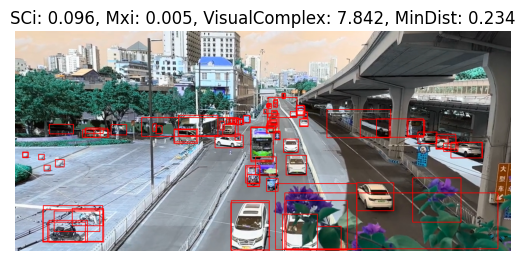

In [ ]:
import torch
from torchvision import models, transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1. 加载预训练的Mask R-CNN模型
model = models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()  # 设置为评估模式

# 2. 加载图像并进行预处理
def preprocess_image(image_path):
    image = cv2.imread(image_path)  # 读取图像
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # 转换为RGB格式
    transform = transforms.Compose([transforms.ToTensor()])  # 归一化
    image_tensor = transform(image_rgb)  # 转换为tensor
    image_tensor = image_tensor.unsqueeze(0)  # 添加批处理维度
    return image, image_tensor

# 3. 执行目标检测和实例分割
def detect_objects(image_path):
    image, image_tensor = preprocess_image(image_path)
    with torch.no_grad():  # 禁用梯度计算，减少内存消耗
        prediction = model(image_tensor)  # 执行预测
    return image, prediction

# 4. 可视化目标检测和实例分割的结果
def visualize_detection(image, prediction, sc, mxi, visualcomplex, mindist):
    # 在图像上绘制目标的边界框
    for box in prediction[0]['boxes']:
        x1, y1, x2, y2 = box.cpu().numpy()
        cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)

    # 使用matplotlib显示图像
    plt.imshow(image)
    plt.title(f"SCi: {sc:.3f}, Mxi: {mxi:.3f}, VisualComplex: {visualcomplex:.3f}, MinDist: {mindist:.3f}")
    plt.axis('off')  # 隐藏坐标轴
    plt.show()

# 假设你已经计算了 SCi、Mxi、VisualComplex 和 MinDist 的值
sc = 0.096  # 示例值
mxi = 0.005  # 示例值
visualcomplex = 7.842  # 示例值
mindist = 0.234  # 示例值

# 示例图像路径
image_path = "Road4.png"  # 替换为你的图像路径

# 检测目标并可视化结果
image, prediction = detect_objects(image_path)
visualize_detection(image, prediction, sc, mxi, visualcomplex, mindist)

In [ ]:
#Video
import torch
from torchvision import models, transforms
import cv2
import numpy as np
import pandas as pd

#######################
# 1. 加载预训练的 Mask R-CNN 模型
#######################
model = models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")
model.eval()

#######################
# 2. 预处理
#######################
def preprocess_image(image):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    transform_fn = transforms.Compose([transforms.ToTensor()])
    image_tensor = transform_fn(image_rgb).unsqueeze(0)  # (1, C, H, W)
    return image_tensor

#######################
# 3. 目标检测
#######################
@torch.no_grad()
def detect_objects(image):
    image_tensor = preprocess_image(image)
    prediction = model(image_tensor)
    return prediction

#######################
# 4. 空间拥堵度计算 (SCi)
#######################
def calculate_space_congestion(image, boxes, grid_size=(50, 50)):
    """
    计算空间拥堵度 (SCi)。
    """
    height, width, _ = image.shape
    num_grids_x = width // grid_size[0]
    num_grids_y = height // grid_size[1]
    if num_grids_x == 0 or num_grids_y == 0:
        return 0

    grid_counts = np.zeros((num_grids_y, num_grids_x))
    for box in boxes:
        x1, y1, x2, y2 = box
        gx1, gy1 = int(x1 // grid_size[0]), int(y1 // grid_size[1])
        gx2, gy2 = int(x2 // grid_size[0]), int(y2 // grid_size[1])

        gx1 = max(0, gx1)
        gy1 = max(0, gy1)
        gx2 = min(num_grids_x - 1, gx2)
        gy2 = min(num_grids_y - 1, gy2)

        grid_counts[gy1:gy2 + 1, gx1:gx2 + 1] += 1

    total_density = grid_counts.sum() / (num_grids_x * num_grids_y)
    max_count = np.max(grid_counts)
    if max_count == 0:
        return 0

    congestion_score = total_density / max_count
    return congestion_score

#######################
# 5. 视觉复杂度计算 (VisualComplex)
#######################
def calculate_visual_complexity(frame):
    """
    使用灰度图熵(Entropy)衡量视觉复杂度。
    """
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
    hist_norm = hist.ravel() / hist.sum()
    epsilon = 1e-7
    entropy = -np.sum(hist_norm * np.log2(hist_norm + epsilon))
    return entropy

#######################
# 6. 最小距离计算 (MinDist)
#######################
def calculate_min_distance(boxes):
    """
    计算所有目标之间的最小距离。
    """
    if len(boxes) < 2:
        return float('inf')

    centers = [((b[0] + b[2]) / 2, (b[1] + b[3]) / 2) for b in boxes]
    min_dist = float('inf'
                    )
    for i in range(len(centers)):
        for j in range(i + 1, len(centers)):
            dist = np.linalg.norm(np.array(centers[i]) - np.array(centers[j]))
            min_dist = min(min_dist, dist)
    return min_dist

#######################
# 7. 新混行严重度计算 (New Mxi)
#######################
def calculate_new_mxi(image, prediction):
    """
    计算基于不同交通主体类型的新的混行严重度。
    """
    boxes = prediction[0]['boxes'].cpu().numpy()
    labels = prediction[0]['labels'].cpu().numpy()
    scores = prediction[0]['scores'].cpu().numpy()

    threshold = 0.5
    valid_indices = scores >= threshold
    boxes = boxes[valid_indices]
    labels = labels[valid_indices]

    type_weights = {
        (1, 2): 2.0, (1, 3): 1.5, (1, 4): 2.5,
        (2, 3): 1.5, (2, 4): 2.0, (3, 4): 1.8,
        (1, 1): 1.0, (2, 2): 1.0, (3, 3): 1.0,
        (4, 4): 1.2
    }

    interaction_sum = 0
    total_pairs = 0
    for i in range(len(boxes)):
        for j in range(i + 1, len(boxes)):
            type_i = labels[i]
            type_j = labels[j]
            dist = np.linalg.norm(np.array([(boxes[i][0] + boxes[i][2]) / 2, (boxes[i][1] + boxes[i][3]) / 2]) -
                                  np.array([(boxes[j][0] + boxes[j][2]) / 2, (boxes[j][1] + boxes[j][3]) / 2]))
            weight = type_weights.get((min(type_i, type_j), max(type_i, type_j)), 1.0)
            interaction_sum += weight / (dist + 1e-5)
            total_pairs += 1

    mxi_new = interaction_sum / total_pairs if total_pairs > 0 else 0
    return mxi_new

#######################
# 8. 综合近距冲突频次计算
#######################
def compute_time_conflict_frequency(mxi_values, min_distances, mxi_threshold, dist_threshold, time_interval=1.0):
    """
    综合基于 New Mxi 和 MinDist 计算近距冲突频次。
    """
    conflict_count = sum(
        1 for mxi, dist in zip(mxi_values, min_distances)
        if mxi > mxi_threshold or dist < dist_threshold
    )
    total_seconds = len(mxi_values) * time_interval
    conflicts_per_second = conflict_count / total_seconds if total_seconds > 0 else 0
    return conflicts_per_second

#######################
# 9. 视频分析
#######################
def analyze_video(video_path, output_path=None, mxi_threshold=0.005, dist_threshold=50, time_interval=1.0):
    cap = cv2.VideoCapture(video_path)
    results = []
    mxi_values = []
    min_distances = []

    if output_path:
        fourcc = cv2.VideoWriter_fourcc(*'XVID')
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    else:
        out = None

    frame_idx = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        prediction = detect_objects(frame)
        boxes = prediction[0]['boxes'].cpu().numpy() if len(prediction[0]['boxes']) else []
        sc = calculate_space_congestion(frame, boxes)
        mxi = calculate_new_mxi(frame, prediction)
        vc = calculate_visual_complexity(frame)
        min_dist = calculate_min_distance(boxes)

        mxi_values.append(mxi)
        min_distances.append(min_dist)

        results.append((frame_idx, sc, mxi, vc, min_dist))

        if out:
            for box in boxes:
                x1, y1, x2, y2 = map(int, box)
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            out.write(frame)

        print(f"Frame {frame_idx}: SCi={sc:.3f}, New Mxi={mxi:.3f}, VisualComplex={vc:.3f}, MinDist={min_dist:.3f}")
        frame_idx += 1

    near_conflict_freq = compute_time_conflict_frequency(
        mxi_values, min_distances, mxi_threshold, dist_threshold, time_interval
    )
    print(f"\n=== 视频近距冲突频次: {near_conflict_freq:.3f} 次/秒 ===")

    df = pd.DataFrame(results, columns=['Frame', 'SCi', 'New Mxi', 'VisualComplex', 'MinDist'])
    df.to_csv('video_analysis_results.csv', index=False)
    print("结果已保存: video_analysis_results.csv")

    cap.release()
    if out:
        out.release()
    return df, near_conflict_freq

#######################
# 10. 主程序调用
#######################
if __name__ == "__main__":
    video_path = 'videoplayback2.mp4'
    output_path = 'output_video1.avi'

    df, conflict_per_second = analyze_video(video_path, output_path)

    print("\n分析结束.")
    print(df)
    print(f"近距冲突频次(次/秒): {conflict_per_second:.3f}")

Frame 0: SCi=0.132, New Mxi=0.006, VisualComplex=7.673, MinDist=0.474
Frame 1: SCi=0.132, New Mxi=0.007, VisualComplex=7.669, MinDist=0.418
Frame 2: SCi=0.147, New Mxi=0.007, VisualComplex=7.664, MinDist=0.134
Frame 3: SCi=0.081, New Mxi=0.007, VisualComplex=7.661, MinDist=0.258
Frame 4: SCi=0.118, New Mxi=0.007, VisualComplex=7.661, MinDist=0.087
Frame 5: SCi=0.119, New Mxi=0.012, VisualComplex=7.650, MinDist=0.193
Frame 6: SCi=0.189, New Mxi=0.009, VisualComplex=7.650, MinDist=0.236
Frame 7: SCi=0.111, New Mxi=0.006, VisualComplex=7.649, MinDist=0.291
Frame 8: SCi=0.131, New Mxi=0.008, VisualComplex=7.646, MinDist=0.310
Frame 9: SCi=0.091, New Mxi=0.006, VisualComplex=7.643, MinDist=0.063
Frame 10: SCi=0.129, New Mxi=0.007, VisualComplex=7.644, MinDist=0.099
Frame 11: SCi=0.116, New Mxi=0.008, VisualComplex=7.639, MinDist=0.396
Frame 12: SCi=0.130, New Mxi=0.007, VisualComplex=7.641, MinDist=0.280
Frame 13: SCi=0.106, New Mxi=0.008, VisualComplex=7.639, MinDist=0.502
Frame 14: SCi=0.